In [1]:
import os, pickle, re, glob, time
import pandas as pd
import numpy as np
np.set_printoptions(precision=2)

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter

sns.set_style('ticks')
pd.set_option('precision', 2)

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
mpl.rc("savefig", dpi=300)

### Figure 1A

``A02-3_itth_scores``

### Figure 1B

``See tcga_deconvolution/scripts/scpt_plots/drug/entropy_vs_drug_resp_lorna_nok.ipynb``

In [3]:
entropy_vs_drug_resp_df = pd.read_csv('../result/CIBERSORT_deconvolution/entropy_vs_drug_resp_df.csv')
entropy_vs_drug_resp_df.head()

patient    drug_name          response acronym  entropy
0  TCGA-OU-A5PI    Etoposide    Stable Disease     ACC     1.90
1  TCGA-OU-A5PI  Doxorubicin    Stable Disease     ACC     1.90
2  TCGA-OU-A5PI    Cisplatin    Stable Disease     ACC     1.90
3  TCGA-OU-A5PI  Carboplatin    Stable Disease     ACC     1.90
4  TCGA-G2-A2EC  Doxorubicin  Partial Response    BLCA     2.04

Change response label to "Response" and "No Response"

**2020-05-28** 
- Change Stable Disease to Response
- Change from minimum 100 patients to 50 patients

In [4]:
response_label = ['Complete Response', 'Partial Response', 'Stable Disease', 'Clinical Progressive Disease']

entropy_vs_drug_resp_df.loc[entropy_vs_drug_resp_df['response'].isin(['Complete Response', 'Partial Response', 'Stable Disease']), 'response2'] = 'Response'
entropy_vs_drug_resp_df.loc[entropy_vs_drug_resp_df['response'].isin(['Clinical Progressive Disease']), 'response2'] = 'No Response'

In [5]:
count_df = entropy_vs_drug_resp_df.groupby(by=['drug_name', 'response']).size().reset_index().pivot(index='drug_name', columns='response', values=0)
# count_df = entropy_vs_drug_resp_df.groupby(by=['drug_name']).size()

In [6]:
count_df

response          Clinical Progressive Disease  Complete Response  \
drug_name                                                           
Bleomycin                                  3.0               35.0   
Capecitabine                              11.0               27.0   
Carboplatin                               43.0               95.0   
Cisplatin                                 45.0              208.0   
Cyclophosphamide                           3.0               93.0   
Docetaxel                                 30.0               65.0   
Doxorubicin                               21.0               59.0   
Etoposide                                  7.0               60.0   
Fluorouracil                              41.0               79.0   
Gemcitabine                               70.0               63.0   
Leucovorin                                18.0               17.0   
Oxaliplatin                               14.0               16.0   
Paclitaxel                                34.0               94.0   
Temozolomide                              25.0                7.0   

response          Partial Response  Stable Disease  
drug_name                                           
Bleomycin                     12.0             3.0  
Capecitabine                   NaN             2.0  
Carboplatin                   14.0            12.0  
Cisplatin                     31.0            22.0  
Cyclophosphamide               2.0             3.0  
Docetaxel                      2.0             7.0  
Doxorubicin                    7.0            12.0  
Etoposide                     12.0             4.0  
Fluorouracil                   4.0             8.0  
Gemcitabine                   11.0            13.0  
Leucovorin                     2.0             1.0  
Oxaliplatin                    2.0             3.0  
Paclitaxel                    13.0            15.0  
Temozolomide                   3.0            60.0

In [7]:
# selected_drugs = count_df.index[(count_df['No Response'] >= 10) & (count_df['Response'] >= 10)]
selected_drugs = count_df.index[(count_df['Clinical Progressive Disease'] >= 15) & (count_df['Complete Response'] >= 15)]
# selected_drugs = count_df.index[count_df >= 50]

In [8]:
entropy_vs_drug_resp_df['acronym'].unique().shape

(24,)

In [9]:
entropy_vs_drug_resp_df = entropy_vs_drug_resp_df[entropy_vs_drug_resp_df['drug_name'].isin(selected_drugs)].sort_values('drug_name')

In [10]:
entropy_vs_drug_resp_df['acronym'].unique().shape

(24,)

##### Supplementary figure

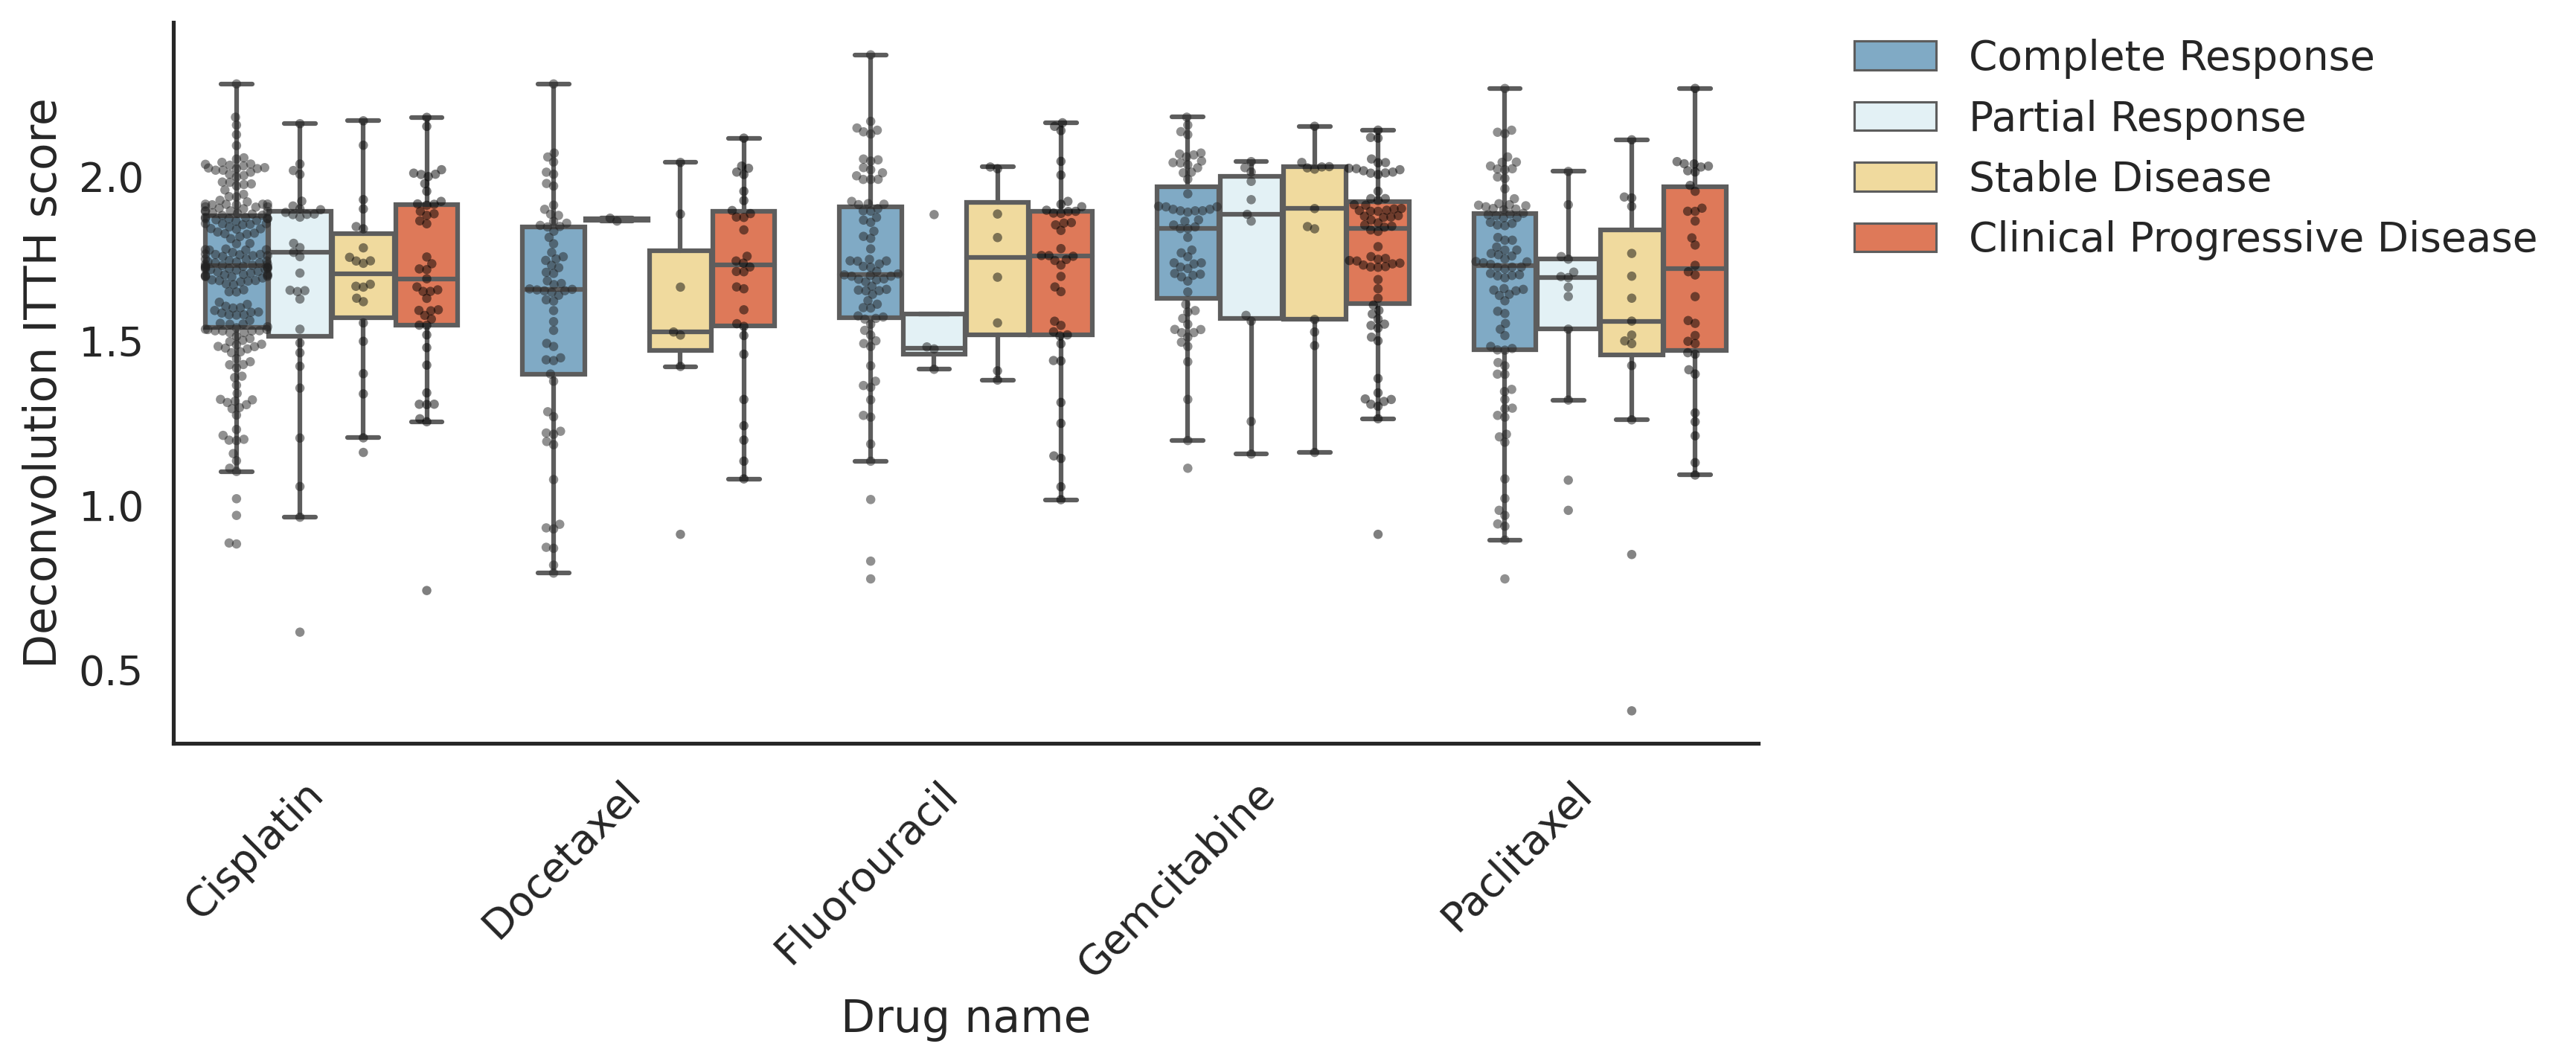

In [11]:
# Plot for all drugs

# order = ['Response', 'No Response']
order = ['Complete Response', 'Partial Response', 'Stable Disease', 'Clinical Progressive Disease']

sns.set(font_scale=1.2)
sns.set_style('white')

fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(x='drug_name', y='entropy', hue='response', 
            data=entropy_vs_drug_resp_df[~entropy_vs_drug_resp_df['drug_name'].isin(['Doxorubicin', 'Carboplatin', 'Leucovorin'])], 
            hue_order=order, showfliers=False, palette='RdYlBu_r', ax=ax, boxprops=dict(alpha=1))

sns.swarmplot(x='drug_name', y='entropy', hue='response', 
              data=entropy_vs_drug_resp_df[~entropy_vs_drug_resp_df['drug_name'].isin(['Doxorubicin', 'Carboplatin', 'Leucovorin'])], 
              hue_order=order, dodge=True, color='black', size=3, alpha=0.5, ax=ax)

ax.legend(title='Drug Response', bbox_to_anchor=(1.05, 1))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
# plt.title('Shannon entropy vs Drug response')

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:4], labels[0:4], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., framealpha=0)

plt.xlabel('Drug name')
plt.ylabel('Deconvolution ITTH score')

plt.tight_layout()
sns.despine()

plt.savefig('../figure/supplementary_fig1_drug_response_vs_ITTH_4c.svg')
# plt.savefig('../figure/supplementary_fig1_drug_response_vs_ITTH.svg')

In [12]:
pval_list = []
pval_CR_CD_list = []

for d in selected_drugs:
    d_df = entropy_vs_drug_resp_df[entropy_vs_drug_resp_df['drug_name']==d]
    nr_vals = d_df[d_df['response2']=='No Response']['entropy'].values
    r_vals = d_df[d_df['response2']=='Response']['entropy'].values
    rs, pval = stats.ranksums(r_vals, nr_vals)
    pval_list += [pval]
    
    nr_vals = d_df[d_df['response']=='Clinical Progressive Disease']['entropy'].values
    r_vals = d_df[d_df['response']=='Complete Response']['entropy'].values
    rs, pval = stats.ranksums(r_vals, nr_vals)
    pval_CR_CD_list += [pval]    
    
    print (d, d_df[d_df['response']=='Clinical Progressive Disease'].shape[0], d_df[d_df['response']=='Complete Response'].shape[0])


Carboplatin 43 95
Cisplatin 45 208
Docetaxel 30 65
Doxorubicin 21 59
Fluorouracil 41 79
Gemcitabine 70 63
Leucovorin 18 17
Paclitaxel 34 94


In [17]:
18+17

35

In [13]:
from statsmodels.stats.multitest import multipletests

is_pass, cpval, alphac_sidak, alphac_bonf = multipletests(pval_list, alpha=0.05, method='fdr_bh')

for d, cp, ip in zip(selected_drugs, cpval, is_pass):
    print ("{}: {:.2e} {}".format(d, cp, ip))

Carboplatin: 5.01e-02 False
Cisplatin: 9.59e-01 False
Docetaxel: 2.83e-01 False
Doxorubicin: 6.15e-03 True
Fluorouracil: 9.59e-01 False
Gemcitabine: 6.34e-01 False
Leucovorin: 4.77e-02 True
Paclitaxel: 6.34e-01 False


In [14]:
is_pass, cpval, alphac_sidak, alphac_bonf = multipletests(pval_CR_CD_list, alpha=0.05, method='fdr_bh')

for d, cp, ip in zip(selected_drugs, cpval, is_pass):
    print ("{}: {:.2e} {}".format(d, cp, ip))

Carboplatin: 2.06e-02 True
Cisplatin: 9.89e-01 False
Docetaxel: 2.65e-01 False
Doxorubicin: 9.86e-03 True
Fluorouracil: 9.89e-01 False
Gemcitabine: 9.40e-01 False
Leucovorin: 2.06e-02 True
Paclitaxel: 9.40e-01 False


##### Main

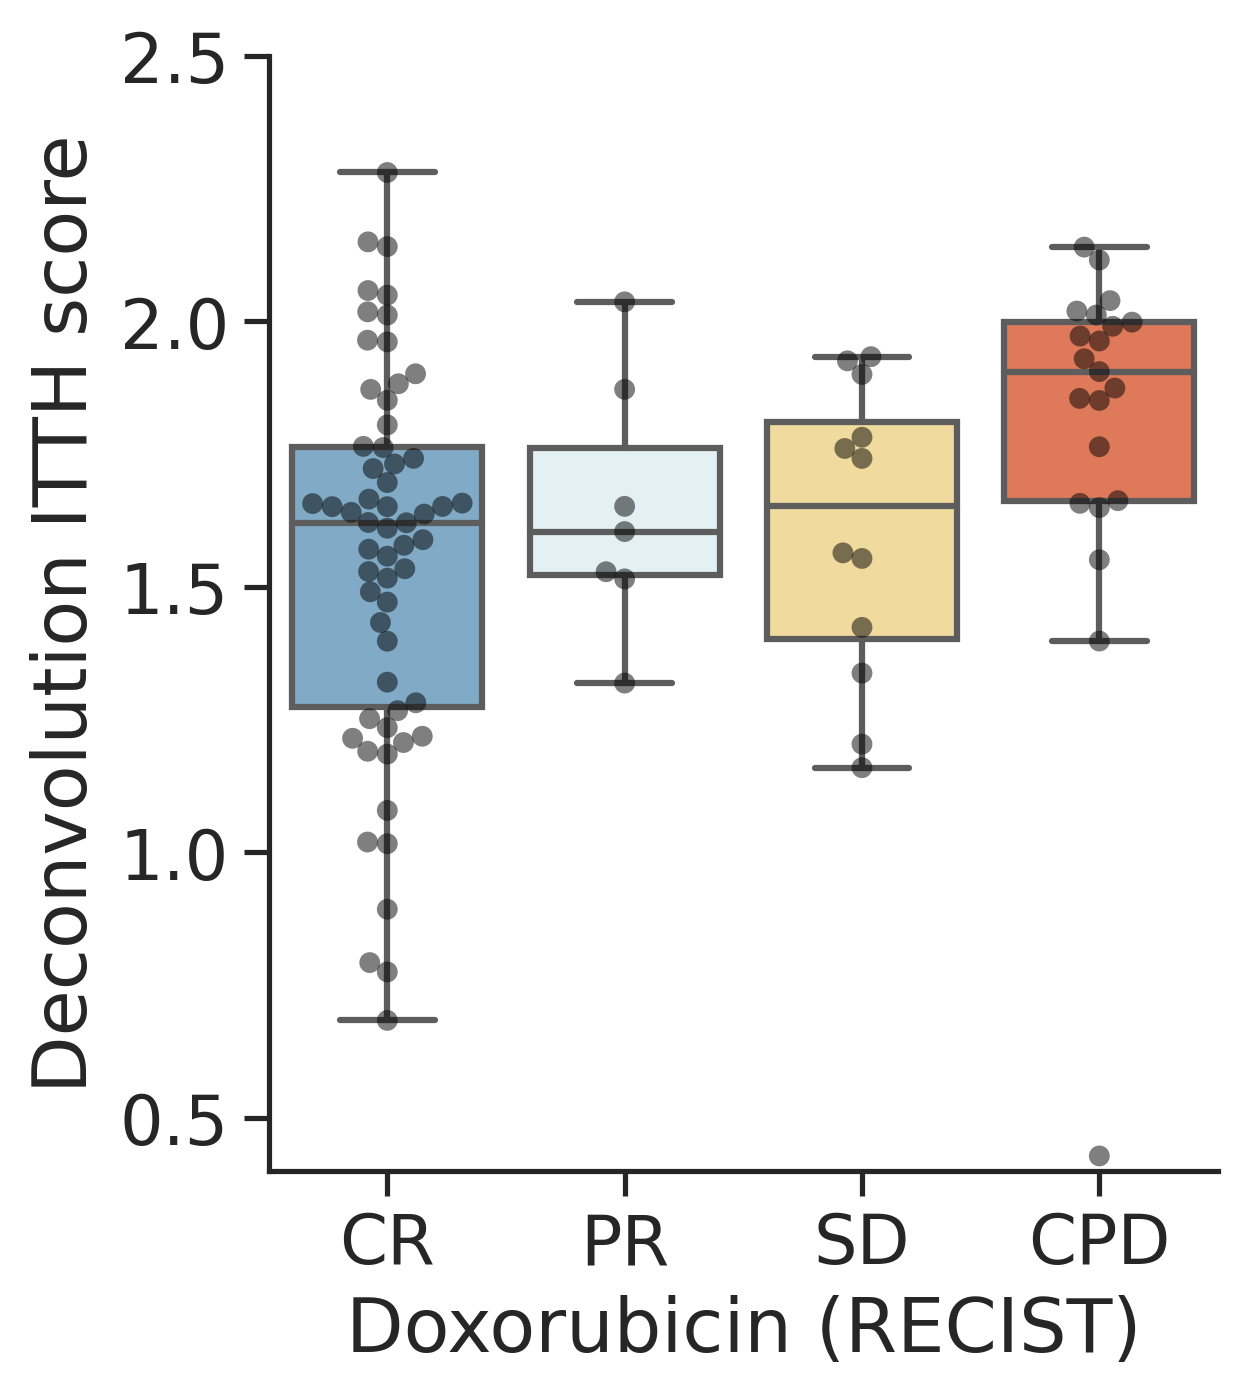

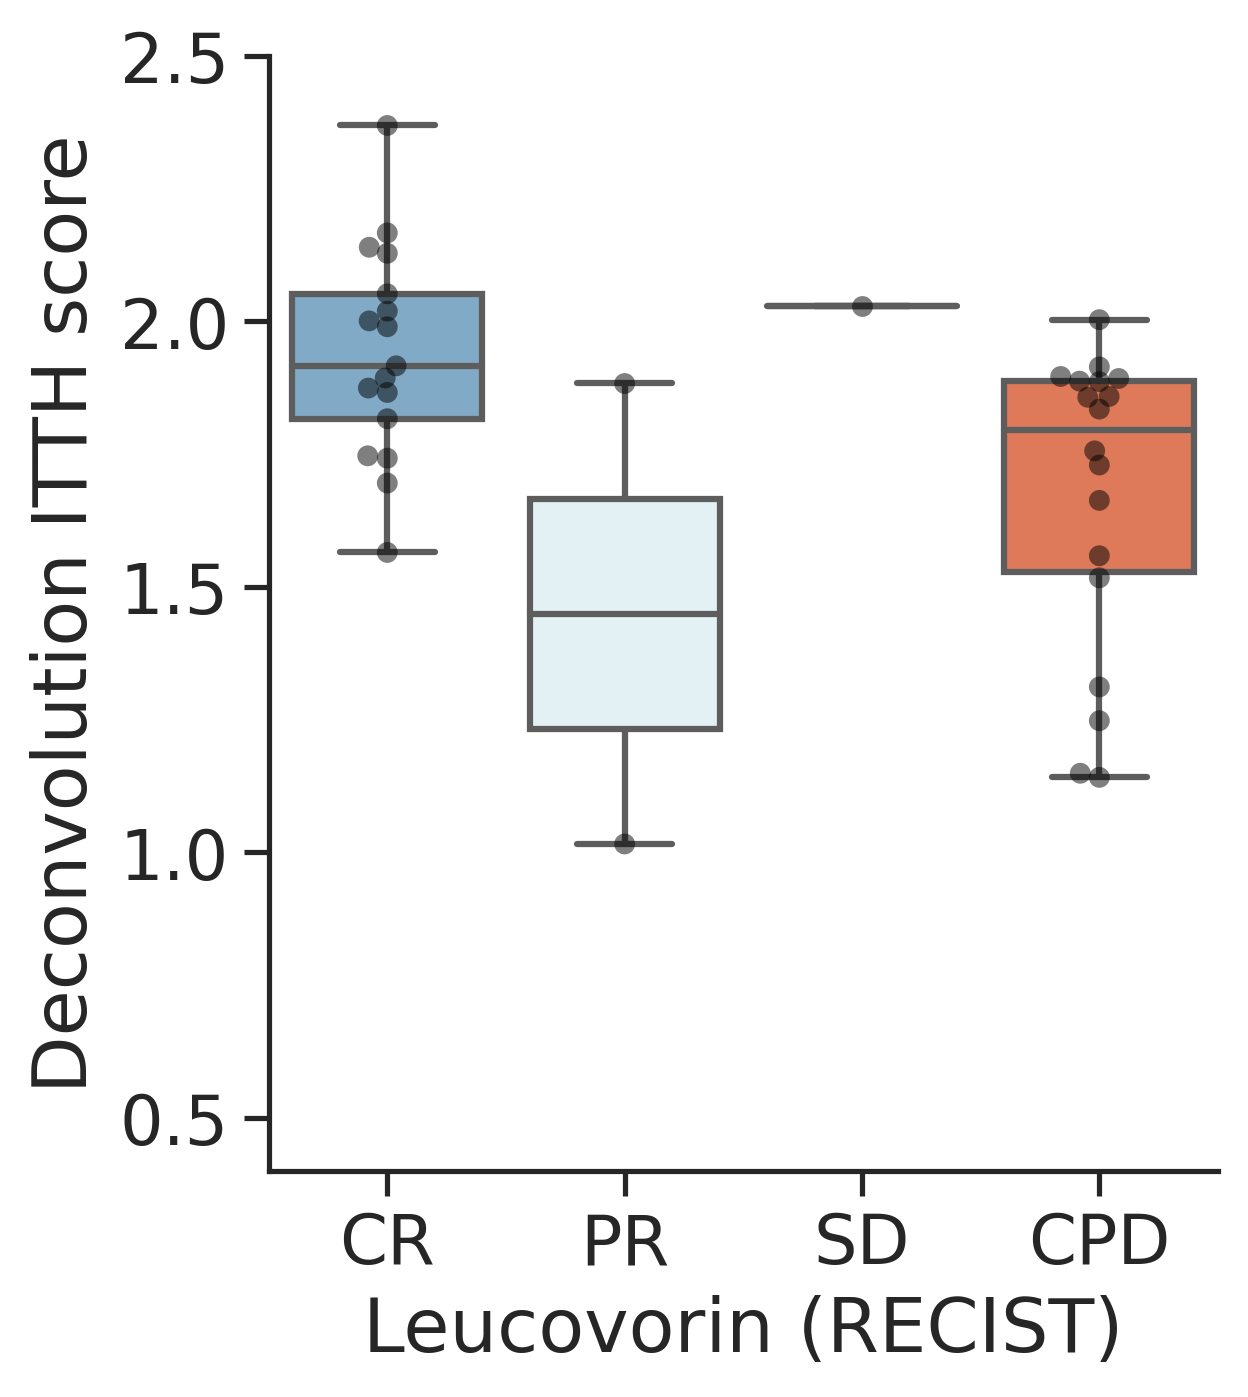

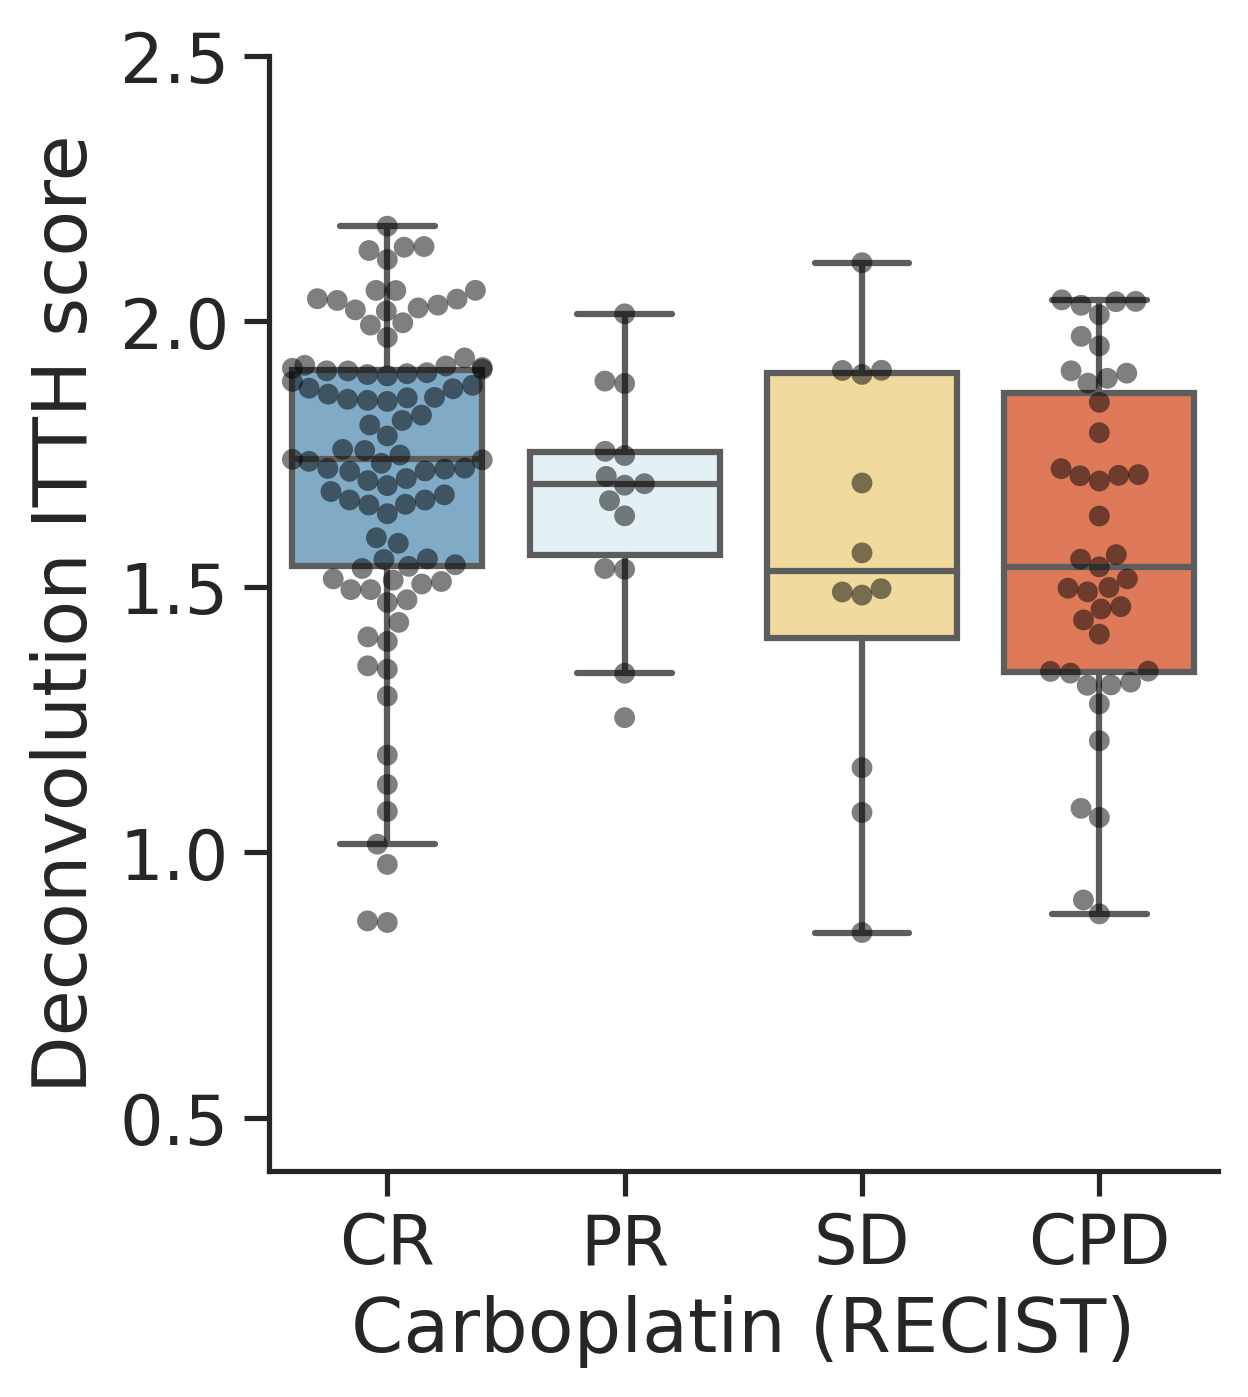

In [15]:
for drug_name in ['Doxorubicin', 'Leucovorin', 'Carboplatin']:
    
    # Plot for a specific drug
    sns.set(style='ticks', font_scale=1.5)
    fig, ax = plt.subplots(figsize=(4.5,5))

#     order = ['Response', 'No Response']
    order = ['Complete Response', 'Partial Response', 'Stable Disease', 'Clinical Progressive Disease']
    order_short = ['CR', 'PR', 'SD', 'CPD']

    d_df = entropy_vs_drug_resp_df[entropy_vs_drug_resp_df['drug_name'] == drug_name]

    sns.boxplot(x='response', y='entropy', data=d_df, order=order, showfliers=False, palette='RdYlBu_r', ax=ax) # palette='RdYlBu_r'
    sns.swarmplot(x='response', y='entropy', data=d_df, order=order, color='black', ax=ax, alpha=0.5)
    sns.despine(bottom=False)

    plt.xticks(rotation=0, ha='center')
    _ = ax.set_xticklabels(order_short)
    plt.yticks()
    plt.ylim((0.4, 2.5))
    plt.xlabel('{} (RECIST)'.format(drug_name))
#     plt.xlabel('{}'.format(drug_name))
    plt.ylabel('Deconvolution ITTH score')

    plt.tight_layout()

    plt.savefig('../figure/Figure1C_{}_4c.svg'.format(drug_name))
#     plt.savefig('../figure/Figure1C_{}.svg'.format(drug_name))
#     plt.clf()

### Figure 1C

In [18]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test, pairwise_logrank_test

In [19]:
entropy_df = pd.read_csv('../result/CIBERSORT_deconvolution/entropy_df.csv')
print (entropy_df.shape)
entropy_df.head()

(9545, 3)


patient acronym  entropy
0  TCGA-02-0047     GBM     2.15
1  TCGA-02-0055     GBM     1.69
2  TCGA-02-2483     GBM     1.72
3  TCGA-02-2485     GBM     1.58
4  TCGA-02-2486     GBM     2.05

In [20]:
q1 = np.percentile(entropy_df['entropy'], 25)
q3 = np.percentile(entropy_df['entropy'], 75)
bins = np.array([0, q1, q3])
entropy_classes = np.digitize(entropy_df['entropy'], bins)

entropy_df.loc[:, 'entropy_bin'] = entropy_classes

bin_map = {1:'Low', 2:'Med', 3:'High'}
entropy_df.loc[:, 'entropy_class'] = entropy_df['entropy_bin'].replace(bin_map)

bin_map = {1:'Low', 2:'Med/High', 3:'Med/High'}
entropy_df.loc[:, 'entropy_class2'] = entropy_df['entropy_bin'].replace(bin_map)

bin_map = {1:'Low/Med', 2:'Low/Med', 3:'High'}
entropy_df.loc[:, 'entropy_class3'] = entropy_df['entropy_bin'].replace(bin_map)

entropy_df.head()

patient acronym  entropy  entropy_bin entropy_class entropy_class2  \
0  TCGA-02-0047     GBM     2.15            3          High       Med/High   
1  TCGA-02-0055     GBM     1.69            2           Med       Med/High   
2  TCGA-02-2483     GBM     1.72            2           Med       Med/High   
3  TCGA-02-2485     GBM     1.58            2           Med       Med/High   
4  TCGA-02-2486     GBM     2.05            3          High       Med/High   

  entropy_class3  
0           High  
1        Low/Med  
2        Low/Med  
3        Low/Med  
4           High

In [21]:
# dead_alive_map = {'Dead':1, 'Alive':0}

survival_df = pd.read_excel('../data/TCGA/TCGA_survival_paper_mmc1.xlsx', index_col=0)
survival_df.head()

bcr_patient_barcode type  age_at_initial_pathologic_diagnosis  gender  \
1        TCGA-OR-A5J1  ACC                                 58.0    MALE   
2        TCGA-OR-A5J2  ACC                                 44.0  FEMALE   
3        TCGA-OR-A5J3  ACC                                 23.0  FEMALE   
4        TCGA-OR-A5J4  ACC                                 23.0  FEMALE   
5        TCGA-OR-A5J5  ACC                                 30.0    MALE   

    race ajcc_pathologic_tumor_stage    clinical_stage  \
1  WHITE                    Stage II  [Not Applicable]   
2  WHITE                    Stage IV  [Not Applicable]   
3  WHITE                   Stage III  [Not Applicable]   
4  WHITE                    Stage IV  [Not Applicable]   
5  WHITE                   Stage III  [Not Applicable]   

                      histological_type histological_grade  \
1  Adrenocortical carcinoma- Usual Type    [Not Available]   
2  Adrenocortical carcinoma- Usual Type    [Not Available]   
3  Adrenocortical carcinoma- Usual Type    [Not Available]   
4  Adrenocortical carcinoma- Usual Type    [Not Available]   
5  Adrenocortical carcinoma- Usual Type    [Not Available]   

   initial_pathologic_dx_year  ... residual_tumor   OS OS.time  DSS  DSS.time  \
1                      2000.0  ...            NaN  1.0  1355.0  1.0    1355.0   
2                      2004.0  ...            NaN  1.0  1677.0  1.0    1677.0   
3                      2008.0  ...            NaN  0.0  2091.0  0.0    2091.0   
4                      2000.0  ...            NaN  1.0   423.0  1.0     423.0   
5                      2000.0  ...            NaN  1.0   365.0  1.0     365.0   

   DFI DFI.time  PFI PFI.time Redaction  
1  1.0    754.0  1.0    754.0       NaN  
2  NaN      NaN  1.0    289.0       NaN  
3  1.0     53.0  1.0     53.0       NaN  
4  NaN      NaN  1.0    126.0       NaN  
5  NaN      NaN  1.0     50.0       NaN  

[5 rows x 33 columns]

In [22]:
survival_df.head(1).T

1
bcr_patient_barcode                                          TCGA-OR-A5J1
type                                                                  ACC
age_at_initial_pathologic_diagnosis                                    58
gender                                                               MALE
race                                                                WHITE
ajcc_pathologic_tumor_stage                                      Stage II
clinical_stage                                           [Not Applicable]
histological_type                    Adrenocortical carcinoma- Usual Type
histological_grade                                        [Not Available]
initial_pathologic_dx_year                                          2e+03
menopause_status                                          [Not Available]
birth_days_to                                                    -2.1e+04
vital_status                                                         Dead
tumor_status                                                   WITH TUMOR
last_contact_days_to                                                  NaN
death_days_to                                                     1.4e+03
cause_of_death                                            [Not Available]
new_tumor_event_type                                   Distant Metastasis
new_tumor_event_site                                  Peritoneal Surfaces
new_tumor_event_site_other                                            NaN
new_tumor_event_dx_days_to                                        7.5e+02
treatment_outcome_first_course                Complete Remission/Response
margin_status                                                         NaN
residual_tumor                                                        NaN
OS                                                                      1
OS.time                                                           1.4e+03
DSS                                                                     1
DSS.time                                                          1.4e+03
DFI                                                                     1
DFI.time                                                          7.5e+02
PFI                                                                     1
PFI.time                                                          7.5e+02
Redaction                                                             NaN

In [23]:
survival_vs_entropy_df = pd.merge(entropy_df, survival_df, left_on='patient', right_on='bcr_patient_barcode')
survival_vs_entropy_df.head()

patient acronym  entropy  entropy_bin entropy_class entropy_class2  \
0  TCGA-02-0047     GBM     2.15            3          High       Med/High   
1  TCGA-02-0055     GBM     1.69            2           Med       Med/High   
2  TCGA-02-2483     GBM     1.72            2           Med       Med/High   
3  TCGA-02-2485     GBM     1.58            2           Med       Med/High   
4  TCGA-02-2486     GBM     2.05            3          High       Med/High   

  entropy_class3 bcr_patient_barcode type  \
0           High        TCGA-02-0047  GBM   
1        Low/Med        TCGA-02-0055  GBM   
2        Low/Med        TCGA-02-2483  GBM   
3        Low/Med        TCGA-02-2485  GBM   
4           High        TCGA-02-2486  GBM   

   age_at_initial_pathologic_diagnosis  ... residual_tumor   OS OS.time  DSS  \
0                                 78.0  ...            NaN  1.0   448.0  1.0   
1                                 62.0  ...            NaN  1.0    76.0  1.0   
2                                 43.0  ...            NaN  0.0   466.0  0.0   
3                                 53.0  ...            NaN  0.0   470.0  0.0   
4                                 64.0  ...            NaN  1.0   618.0  1.0   

  DSS.time DFI  DFI.time  PFI  PFI.time Redaction  
0    448.0 NaN       NaN  1.0      57.0       NaN  
1     76.0 NaN       NaN  1.0       6.0       NaN  
2    466.0 NaN       NaN  0.0     466.0       NaN  
3    470.0 NaN       NaN  1.0     186.0       NaN  
4    618.0 NaN       NaN  1.0     618.0       NaN  

[5 rows x 40 columns]

##### Supplementary

In [24]:
acronym_list = sorted(survival_vs_entropy_df['acronym'].unique().tolist())
print (len(acronym_list))

cmap = plt.cm.get_cmap('inferno', 10)
low_color = cmap(0.7)
med_color = cmap(0.5)
high_color = cmap(0.25)

33


In [25]:
def check_sig(df):

    results = pairwise_logrank_test(df[duration_label], df['entropy_class'], df[survival_val_type]).summary.reset_index()
    results.loc[:, 'corrected_p'] = results['p'].values * results.shape[0]
    
    results2 = pairwise_logrank_test(df[duration_label], df['entropy_class2'], df[survival_val_type]).summary.reset_index()
    results3 = pairwise_logrank_test(df[duration_label], df['entropy_class3'], df[survival_val_type]).summary.reset_index()
    
    sig_df = pd.concat([results, results2, results3], axis=0)
    sig_df.loc[:, 'acronym'] = a
    
    return sig_df

In [26]:
from sklearn.metrics import auc

def cal_norm_auc(kmf, time_limit):
    df = kmf.survival_function_.copy()
    df = df[df.index <= time_limit]
    x = df.index.values
    y = df.values.flatten()
    x = np.append(x, time_limit)
    y = np.append(y, y[-1])
    return (auc(x, y) / time_limit), df.shape[0]

In [27]:
##### RMST (will be useful later on)

# from lifelines.utils import restricted_mean_survival_time

# from lifelines.plotting import rmst_plot
# from lifelines.utils import restricted_mean_survival_time
# print (restricted_mean_survival_time(kmf_acr, t=4000))

# rmst_plot(kmf_acr, t=4000)

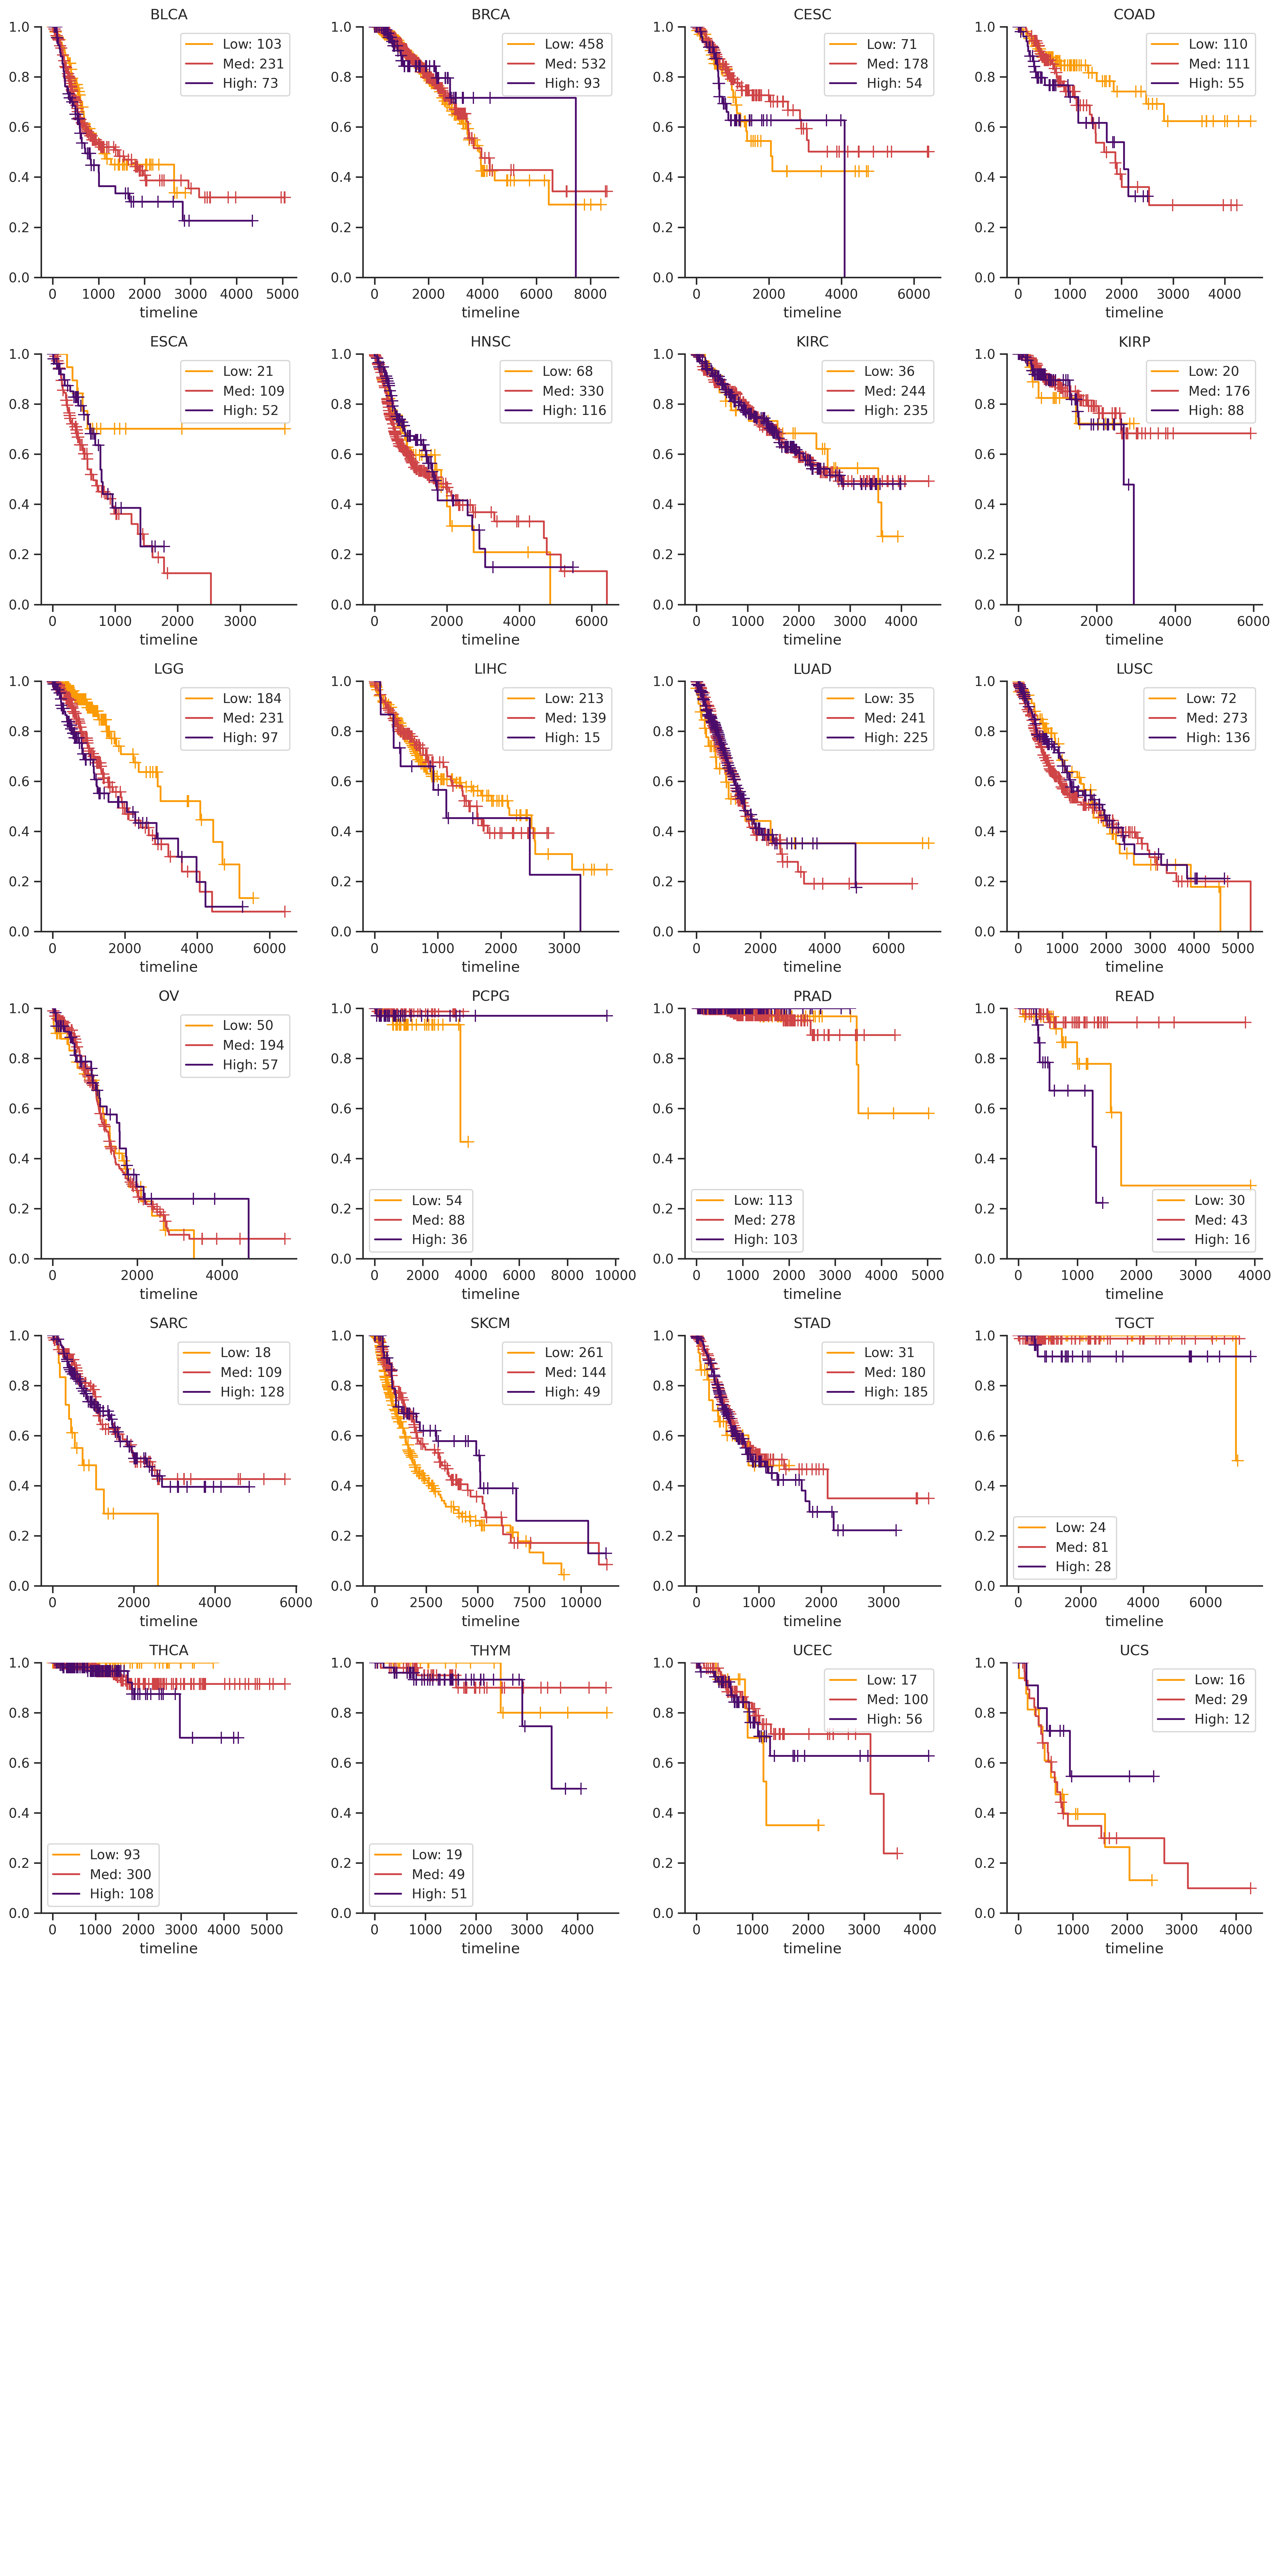

In [28]:
survival_val_type = 'OS' # OS | PFI
duration_label = survival_val_type+'.time'
min_patient = 10

kmf_acr = KaplanMeierFitter()
selected_acronym_list = []

sns.set(font_scale=1, style='ticks')
fig, axes = plt.subplots(8, 4, figsize=(15, 30))

auc_norm_list = []
sig_df_list = []

i = 0
axes = axes.flatten()

for a in acronym_list:
    df = survival_vs_entropy_df[survival_vs_entropy_df.acronym == a]
    df = df.dropna(subset=['entropy_class', duration_label, survival_val_type])
    
    time_limit = df.groupby('entropy_class')[survival_val_type+'.time'].max().min()
    
    df_low = df[df['entropy_class'] == 'Low']
    df_med = df[df['entropy_class'] == 'Med']
    df_high = df[df['entropy_class'] == 'High']
    
    n_low = len(df_low)
    n_med = len(df_med)
    n_high = len(df_high)
    
#     ax.set_xlim(0, 11260)

    if (n_low >= min_patient) and (n_med >= min_patient) and (n_high >= min_patient):
        
        selected_acronym_list += [a]
        ax = axes[i]
        i += 1

        kmf_acr.fit(df_low[duration_label], df_low[survival_val_type], label=('Low: ' + str(n_low)))
        kmf_acr.plot(ax=ax, color=low_color, show_censors=True, censor_styles={'ms': 10, 'marker': '+'}, ci_show=False, ci_alpha=0.1)
        # auc_norm_list += [[a, 'Low', *cal_norm_auc(kmf_acr, time_limit), restricted_mean_survival_time(kmf_acr, t=time_limit)]]
   
        kmf_acr.fit(df_med[duration_label], df_med[survival_val_type], label=('Med: ' + str(n_med)))
        kmf_acr.plot(ax=ax, color=med_color, show_censors=True, censor_styles={'ms': 10, 'marker': '+'}, ci_show=False, ci_alpha=0.1)
        # auc_norm_list += [[a, 'Med', *cal_norm_auc(kmf_acr, time_limit), restricted_mean_survival_time(kmf_acr, t=time_limit)]]

        kmf_acr.fit(df_high[duration_label], df_high[survival_val_type], label=('High: ' + str(n_high)))
        kmf_acr.plot(ax=ax, color=high_color, show_censors=True, censor_styles={'ms': 10, 'marker': '+'}, ci_show=False, ci_alpha=0.1)
        # auc_norm_list += [[a, 'High', *cal_norm_auc(kmf_acr, time_limit), restricted_mean_survival_time(kmf_acr, t=time_limit)]]
    
        ax.set_ylim((0, 1))
        ax.set_title(a)
        sns.despine()

        sig_df_list += [check_sig(df)]
    

for i in range(len(selected_acronym_list), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
# plt.savefig('../figure/supplementary_itth_survival.svg')
# plt.savefig('../figure/supplementary_itth_survival.pdf')

In [29]:
sig_df = pd.concat(sig_df_list, axis=0).sort_values('p')
combined_sig_df = sig_df[sig_df['corrected_p'].isnull()].sort_values(['acronym', 'p']).groupby('acronym').head(1).sort_values('p')
combined_sig_df

level_0   level_1  test_statistic         p  corrected_p acronym
0     Low  Med/High           17.85  2.39e-05          NaN     LGG
0     Low  Med/High           12.33  4.45e-04          NaN    SARC
0    High   Low/Med           12.18  4.83e-04          NaN    READ
0     Low  Med/High            8.26  4.05e-03          NaN    COAD
0     Low  Med/High            7.93  4.86e-03          NaN    SKCM
0     Low  Med/High            4.97  2.58e-02          NaN    ESCA
0     Low  Med/High            3.17  7.49e-02          NaN    THCA
0    High   Low/Med            3.04  8.13e-02          NaN    BLCA
0    High   Low/Med            2.00  1.57e-01          NaN    PRAD
0     Low  Med/High            1.81  1.79e-01          NaN    PCPG
0    High   Low/Med            1.74  1.88e-01          NaN     UCS
0    High   Low/Med            1.73  1.88e-01          NaN    TGCT
0    High   Low/Med            1.43  2.32e-01          NaN    CESC
0     Low  Med/High            1.16  2.82e-01          NaN    UCEC
0    High   Low/Med            1.04  3.08e-01          NaN    LIHC
0    High   Low/Med            0.96  3.27e-01          NaN    THYM
0    High   Low/Med            0.96  3.27e-01          NaN    HNSC
0    High   Low/Med            0.84  3.58e-01          NaN      OV
0    High   Low/Med            0.73  3.91e-01          NaN    KIRP
0    High   Low/Med            0.57  4.51e-01          NaN    LUSC
0     Low  Med/High            0.44  5.07e-01          NaN    STAD
0     Low  Med/High            0.30  5.86e-01          NaN    LUAD
0     Low  Med/High            0.27  6.05e-01          NaN    BRCA
0     Low  Med/High            0.01  9.13e-01          NaN    KIRC

In [30]:
is_pass, cpval, alphac_sidak, alphac_bonf = multipletests(combined_sig_df['p'], alpha=0.1, method='fdr_bh')
is_pass, cpval

(array([ True,  True,  True,  True,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False]),
 array([5.74e-04, 3.87e-03, 3.87e-03, 2.33e-02, 2.33e-02, 1.03e-01,
        2.44e-01, 2.44e-01, 3.76e-01, 3.76e-01, 3.76e-01, 3.76e-01,
        4.28e-01, 4.62e-01, 4.62e-01, 4.62e-01, 4.62e-01, 4.78e-01,
        4.94e-01, 5.41e-01, 5.80e-01, 6.31e-01, 6.31e-01, 9.13e-01]))

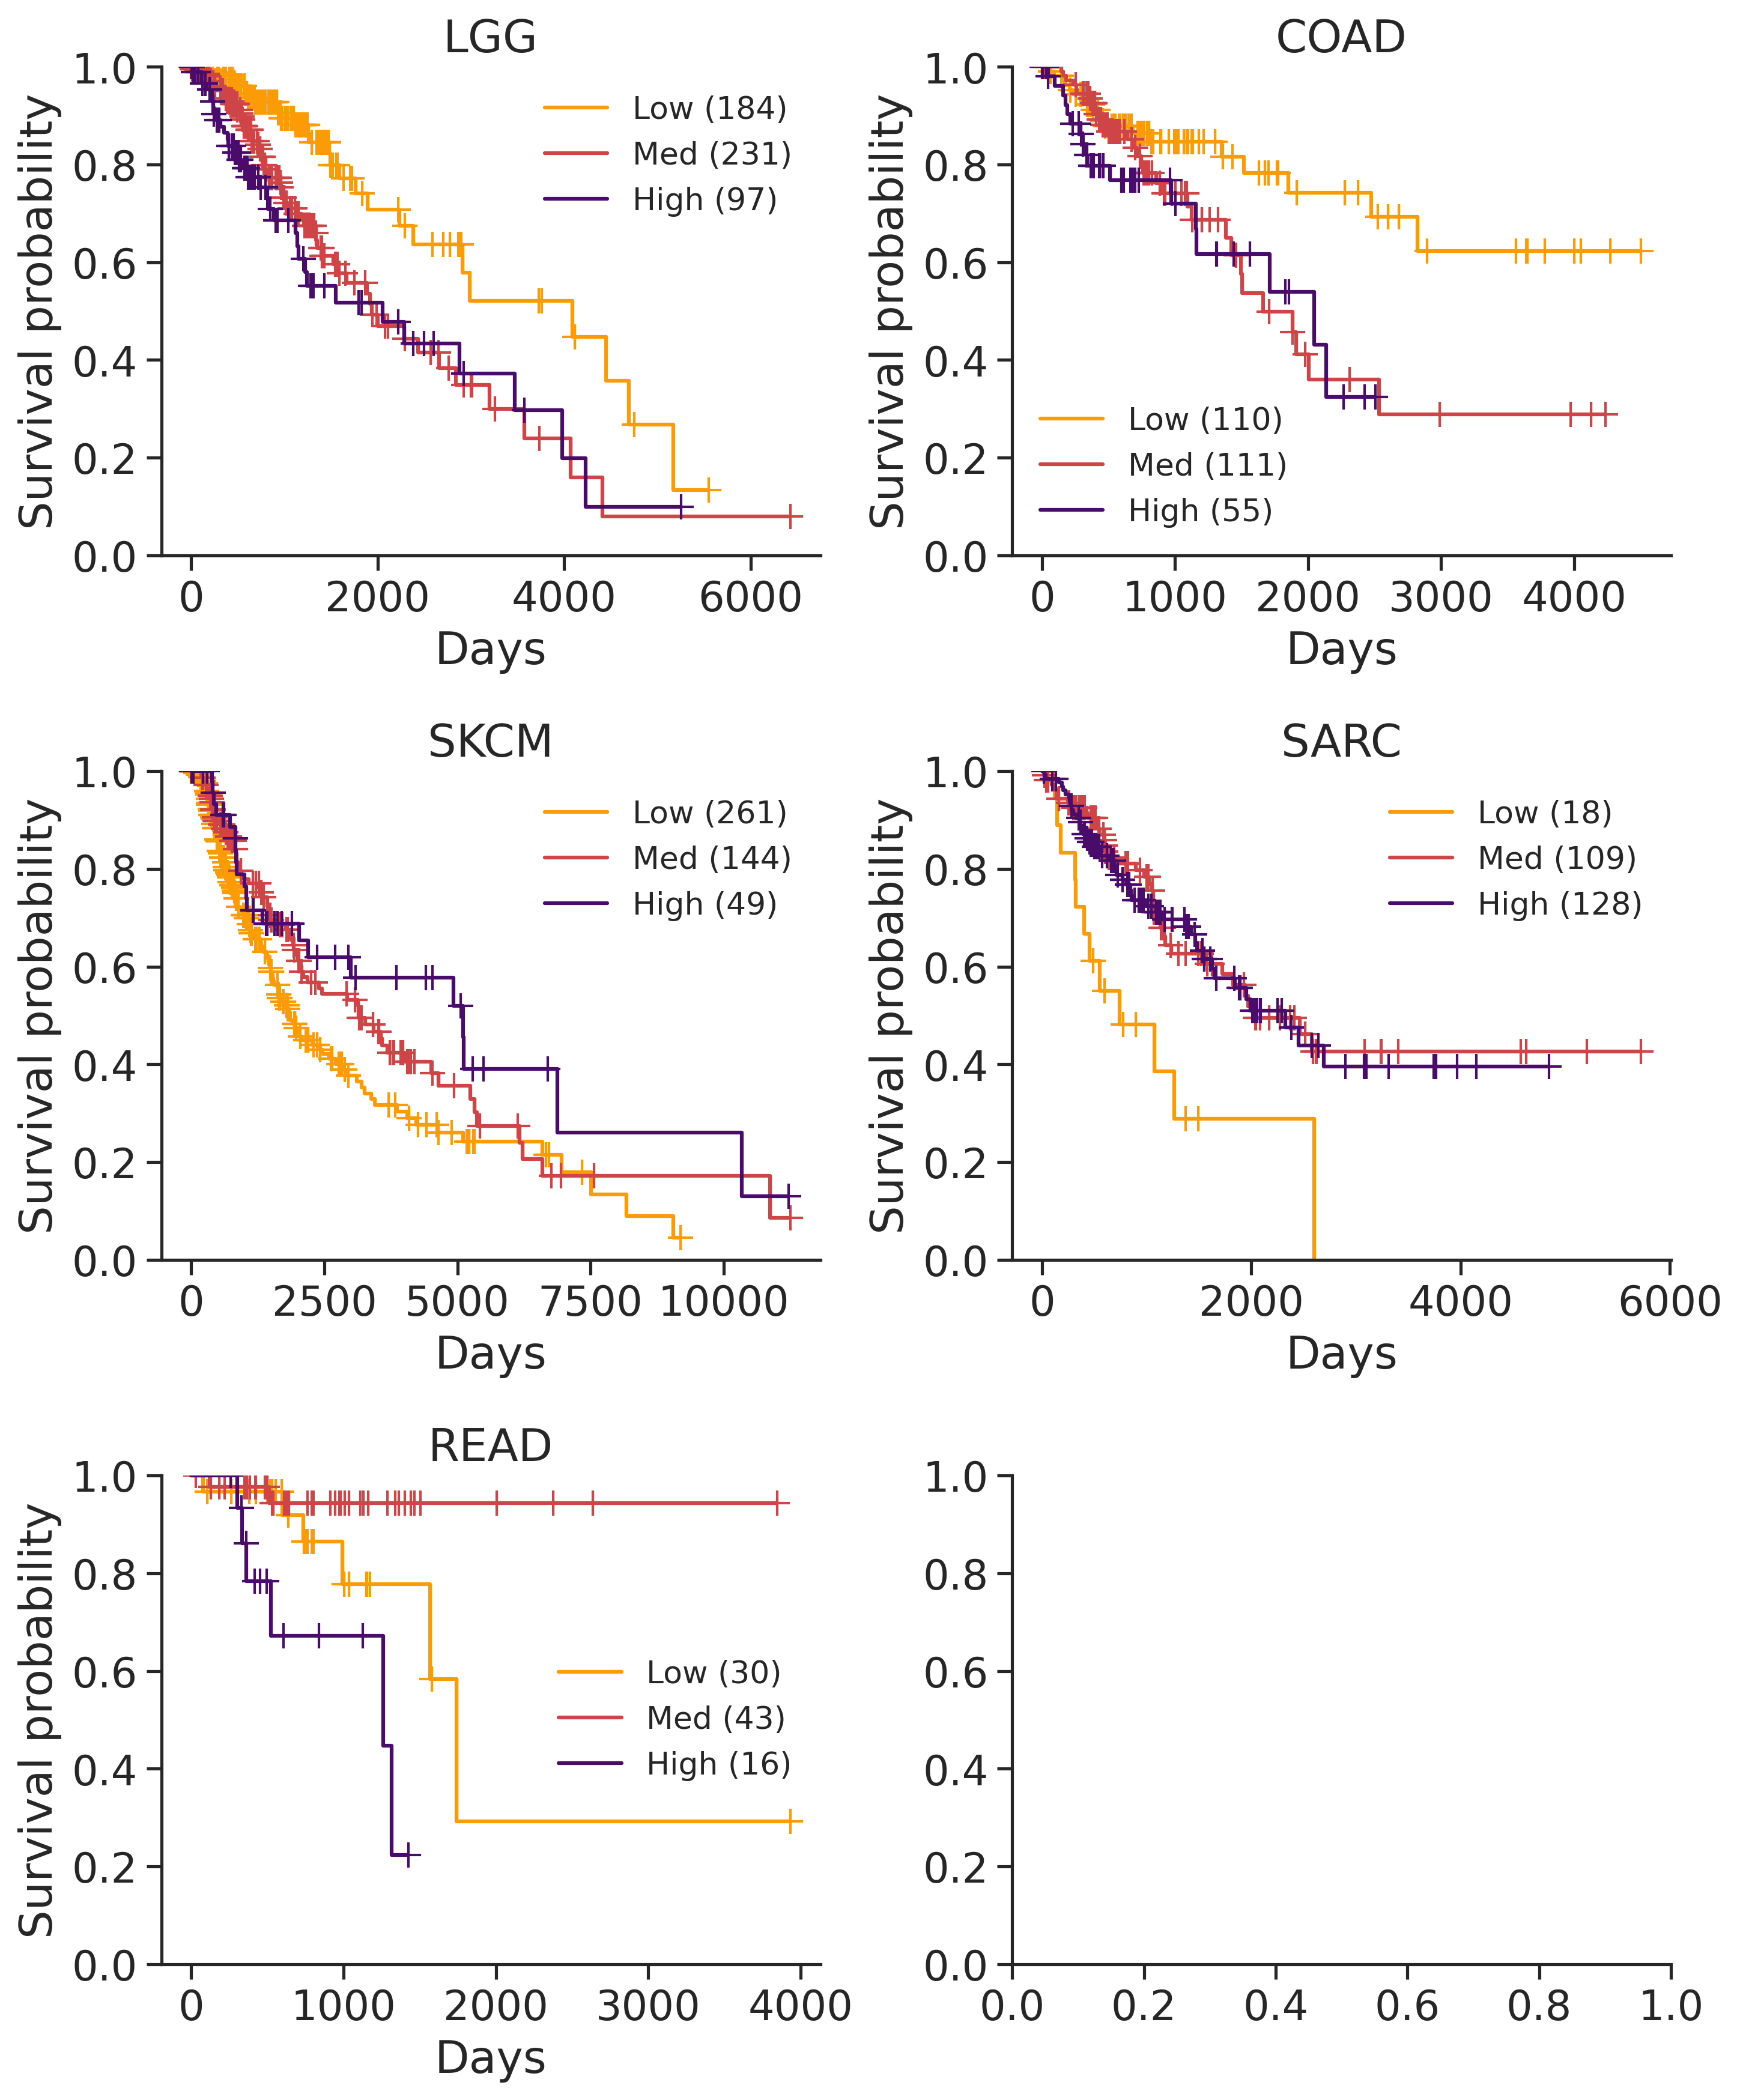

In [31]:
sns.set(style='ticks', font_scale=1.5)
fig, axes = plt.subplots(figsize=(10,12), ncols=2, nrows=3)

for a, ax in zip(['LGG', 'COAD', 'SKCM', 'SARC', 'READ'], axes.flatten()):
    df = survival_vs_entropy_df[survival_vs_entropy_df.acronym == a]
    df = df.dropna(subset=['entropy_class', duration_label, survival_val_type])
    
    df_low = df[df['entropy_class'] == 'Low']
    df_med = df[df['entropy_class'] == 'Med']
    df_high = df[df['entropy_class'] == 'High']
    
    n_low = len(df_low)
    n_med = len(df_med)
    n_high = len(df_high)

    kmf_acr.fit(df_low[duration_label], df_low[survival_val_type], label=('Low ({})'.format(n_low)))
    kmf_acr.plot(ax=ax, color=low_color, show_censors=True, censor_styles={'ms': 10, 'marker': '+'}, ci_show=False, ci_alpha=0.1)
   
    kmf_acr.fit(df_med[duration_label], df_med[survival_val_type], label=('Med ({})'.format(n_med)))
    kmf_acr.plot(ax=ax, color=med_color, show_censors=True, censor_styles={'ms': 10, 'marker': '+'}, ci_show=False, ci_alpha=0.1)

    kmf_acr.fit(df_high[duration_label], df_high[survival_val_type], label=('High ({})'.format(n_high)))
    kmf_acr.plot(ax=ax, color=high_color, show_censors=True, censor_styles={'ms': 10, 'marker': '+'}, ci_show=False, ci_alpha=0.05)
    
    # ax.set_xlim(0, 7000)
    ax.set_ylim(0, 1)
    
    ax.set_title(a)
    ax.set_ylabel('Survival probability')
    ax.set_xlabel('Days')

    ax.legend(frameon=False, loc='best', fontsize='x-small')
    
    sns.despine()

plt.tight_layout()   

# plt.savefig('../figure/Figure1C.svg')

### Figure 1D

Fig D and E using new clustering based on marker genes were added to supplementary

In [32]:
# See nok_nmf_all_cancer_type.ipynb and nok_nmf_all_cancer_type_marker_genes.ipynb and nok_nmf_lifelines.ipynb

cluster_df = pd.read_csv('../data/TCGA/nmf_all_cancer_type.csv', index_col=0)
# cluster_df = pd.read_csv('../data/TCGA/nmf_all_cancer_type_marker_genes.csv', index_col=0)

In [33]:
cluster_df.loc[:, 'patient'] = ['-'.join(p.split('-')[0:3]) for p in cluster_df.index]
cluster_df.index.name = 'sample_id'
cluster_df.loc[:, 'sample_type'] = [int(c.split('-')[3][0:2]) for c in cluster_df.index]
cluster_df = cluster_df[cluster_df['sample_type'] < 10]

cluster_df = cluster_df.reset_index()
cluster_df.head()

sample_id cancer_type  cluster  si_score       patient  \
0  TCGA-OR-A5J1-01A-11R-A29S-07         ACC        0     -0.30  TCGA-OR-A5J1   
1  TCGA-OR-A5J2-01A-11R-A29S-07         ACC        0     -0.29  TCGA-OR-A5J2   
2  TCGA-OR-A5J3-01A-11R-A29S-07         ACC        1      0.17  TCGA-OR-A5J3   
3  TCGA-OR-A5J5-01A-11R-A29S-07         ACC        1      0.14  TCGA-OR-A5J5   
4  TCGA-OR-A5J6-01A-31R-A29S-07         ACC        0      0.10  TCGA-OR-A5J6   

   sample_type  
0            1  
1            1  
2            1  
3            1  
4            1

For patient with multiple samples, keep the cluster with higer si

In [34]:
patient_with_multiple_samples = [k for k, v in Counter(cluster_df['patient']).items() if v > 1]
len(patient_with_multiple_samples)

73

In [35]:
cluster_df.groupby('patient').size().sort_values(ascending=False)

patient
TCGA-06-0211    3
TCGA-TQ-A7RK    3
TCGA-DU-6407    3
TCGA-DU-6404    3
TCGA-SR-A6MX    3
               ..
TCGA-FD-A5BY    1
TCGA-FD-A5BX    1
TCGA-FD-A5BV    1
TCGA-FD-A5BU    1
TCGA-02-0047    1
Length: 9545, dtype: int64

In [36]:
cluster_df = cluster_df.sort_values(['patient', 'si_score'], ascending=[True, False]).drop_duplicates(subset=['patient'], keep='first')

cluster_df = cluster_df.set_index('patient')
cluster_df.shape

(9545, 5)

In [37]:
cluster_df.head()

sample_id cancer_type  cluster  si_score  \
patient                                                                     
TCGA-02-0047  TCGA-02-0047-01A-01R-1849-01         GBM        0      0.33   
TCGA-02-0055  TCGA-02-0055-01A-01R-1849-01         GBM        1      0.18   
TCGA-02-2483  TCGA-02-2483-01A-01R-1849-01         GBM        1      0.40   
TCGA-02-2485  TCGA-02-2485-01A-01R-1849-01         GBM        0     -0.11   
TCGA-02-2486  TCGA-02-2486-01A-01R-1849-01         GBM        2      0.17   

              sample_type  
patient                    
TCGA-02-0047            1  
TCGA-02-0055            1  
TCGA-02-2483            1  
TCGA-02-2485            1  
TCGA-02-2486            1

##### Supplementary

In [38]:
cmap = plt.cm.get_cmap('tab10', 10)
colors = [cmap(i) for i in range(10)]

In [39]:
# from scipy.special import comb

# def check_sig(results, bf_coef):
    
#     text_list = []
#     for _, data in results.summary.reset_index().iterrows():
#         x_name = int(data['level_0']+1)
#         y_name = int(data['level_1']+1)
#         pval = data['p'] * bf_coef

#         text = "TC {}/TC {} ({:.2e})".format(x_name, y_name, pval)

# #         if pval <= 0.05:
# #             text += ' (*)'

#         text_list += [text]

#     ax.set_title('\n'.join([a] + text_list))     

In [40]:
survival_vs_nmf_df = pd.merge(survival_df, cluster_df, left_on='bcr_patient_barcode', right_index=True)
survival_vs_nmf_df.head()

bcr_patient_barcode type  age_at_initial_pathologic_diagnosis  gender  \
1        TCGA-OR-A5J1  ACC                                 58.0    MALE   
2        TCGA-OR-A5J2  ACC                                 44.0  FEMALE   
3        TCGA-OR-A5J3  ACC                                 23.0  FEMALE   
5        TCGA-OR-A5J5  ACC                                 30.0    MALE   
6        TCGA-OR-A5J6  ACC                                 29.0  FEMALE   

                        race ajcc_pathologic_tumor_stage    clinical_stage  \
1                      WHITE                    Stage II  [Not Applicable]   
2                      WHITE                    Stage IV  [Not Applicable]   
3                      WHITE                   Stage III  [Not Applicable]   
5                      WHITE                   Stage III  [Not Applicable]   
6  BLACK OR AFRICAN AMERICAN                    Stage II  [Not Applicable]   

                      histological_type histological_grade  \
1  Adrenocortical carcinoma- Usual Type    [Not Available]   
2  Adrenocortical carcinoma- Usual Type    [Not Available]   
3  Adrenocortical carcinoma- Usual Type    [Not Available]   
5  Adrenocortical carcinoma- Usual Type    [Not Available]   
6  Adrenocortical carcinoma- Usual Type    [Not Available]   

   initial_pathologic_dx_year  ...  DFI  DFI.time  PFI PFI.time  Redaction  \
1                      2000.0  ...  1.0     754.0  1.0    754.0        NaN   
2                      2004.0  ...  NaN       NaN  1.0    289.0        NaN   
3                      2008.0  ...  1.0      53.0  1.0     53.0        NaN   
5                      2000.0  ...  NaN       NaN  1.0     50.0        NaN   
6                      2006.0  ...  0.0    2703.0  0.0   2703.0        NaN   

                      sample_id cancer_type cluster si_score sample_type  
1  TCGA-OR-A5J1-01A-11R-A29S-07         ACC       0    -0.30           1  
2  TCGA-OR-A5J2-01A-11R-A29S-07         ACC       0    -0.29           1  
3  TCGA-OR-A5J3-01A-11R-A29S-07         ACC       1     0.17           1  
5  TCGA-OR-A5J5-01A-11R-A29S-07         ACC       1     0.14           1  
6  TCGA-OR-A5J6-01A-31R-A29S-07         ACC       0     0.10           1  

[5 rows x 38 columns]

In [41]:
def check_sig_nmf(df):

#     results = pairwise_logrank_test(df[duration_label], df['cluster0vs'], df[survival_val_type]).summary.reset_index()
#     results.loc[:, 'corrected_p'] = results['p'].values * results.shape[0]
    
    results1 = pairwise_logrank_test(df[duration_label], df['cluster0vs'], df[survival_val_type]).summary.reset_index()
    results2 = pairwise_logrank_test(df[duration_label], df['cluster1vs'], df[survival_val_type]).summary.reset_index()
    results3 = pairwise_logrank_test(df[duration_label], df['cluster2vs'], df[survival_val_type]).summary.reset_index()
    
    sig_df = pd.concat([results1, results2, results3], axis=0)
    sig_df.loc[:, 'acronym'] = a
    
    return sig_df

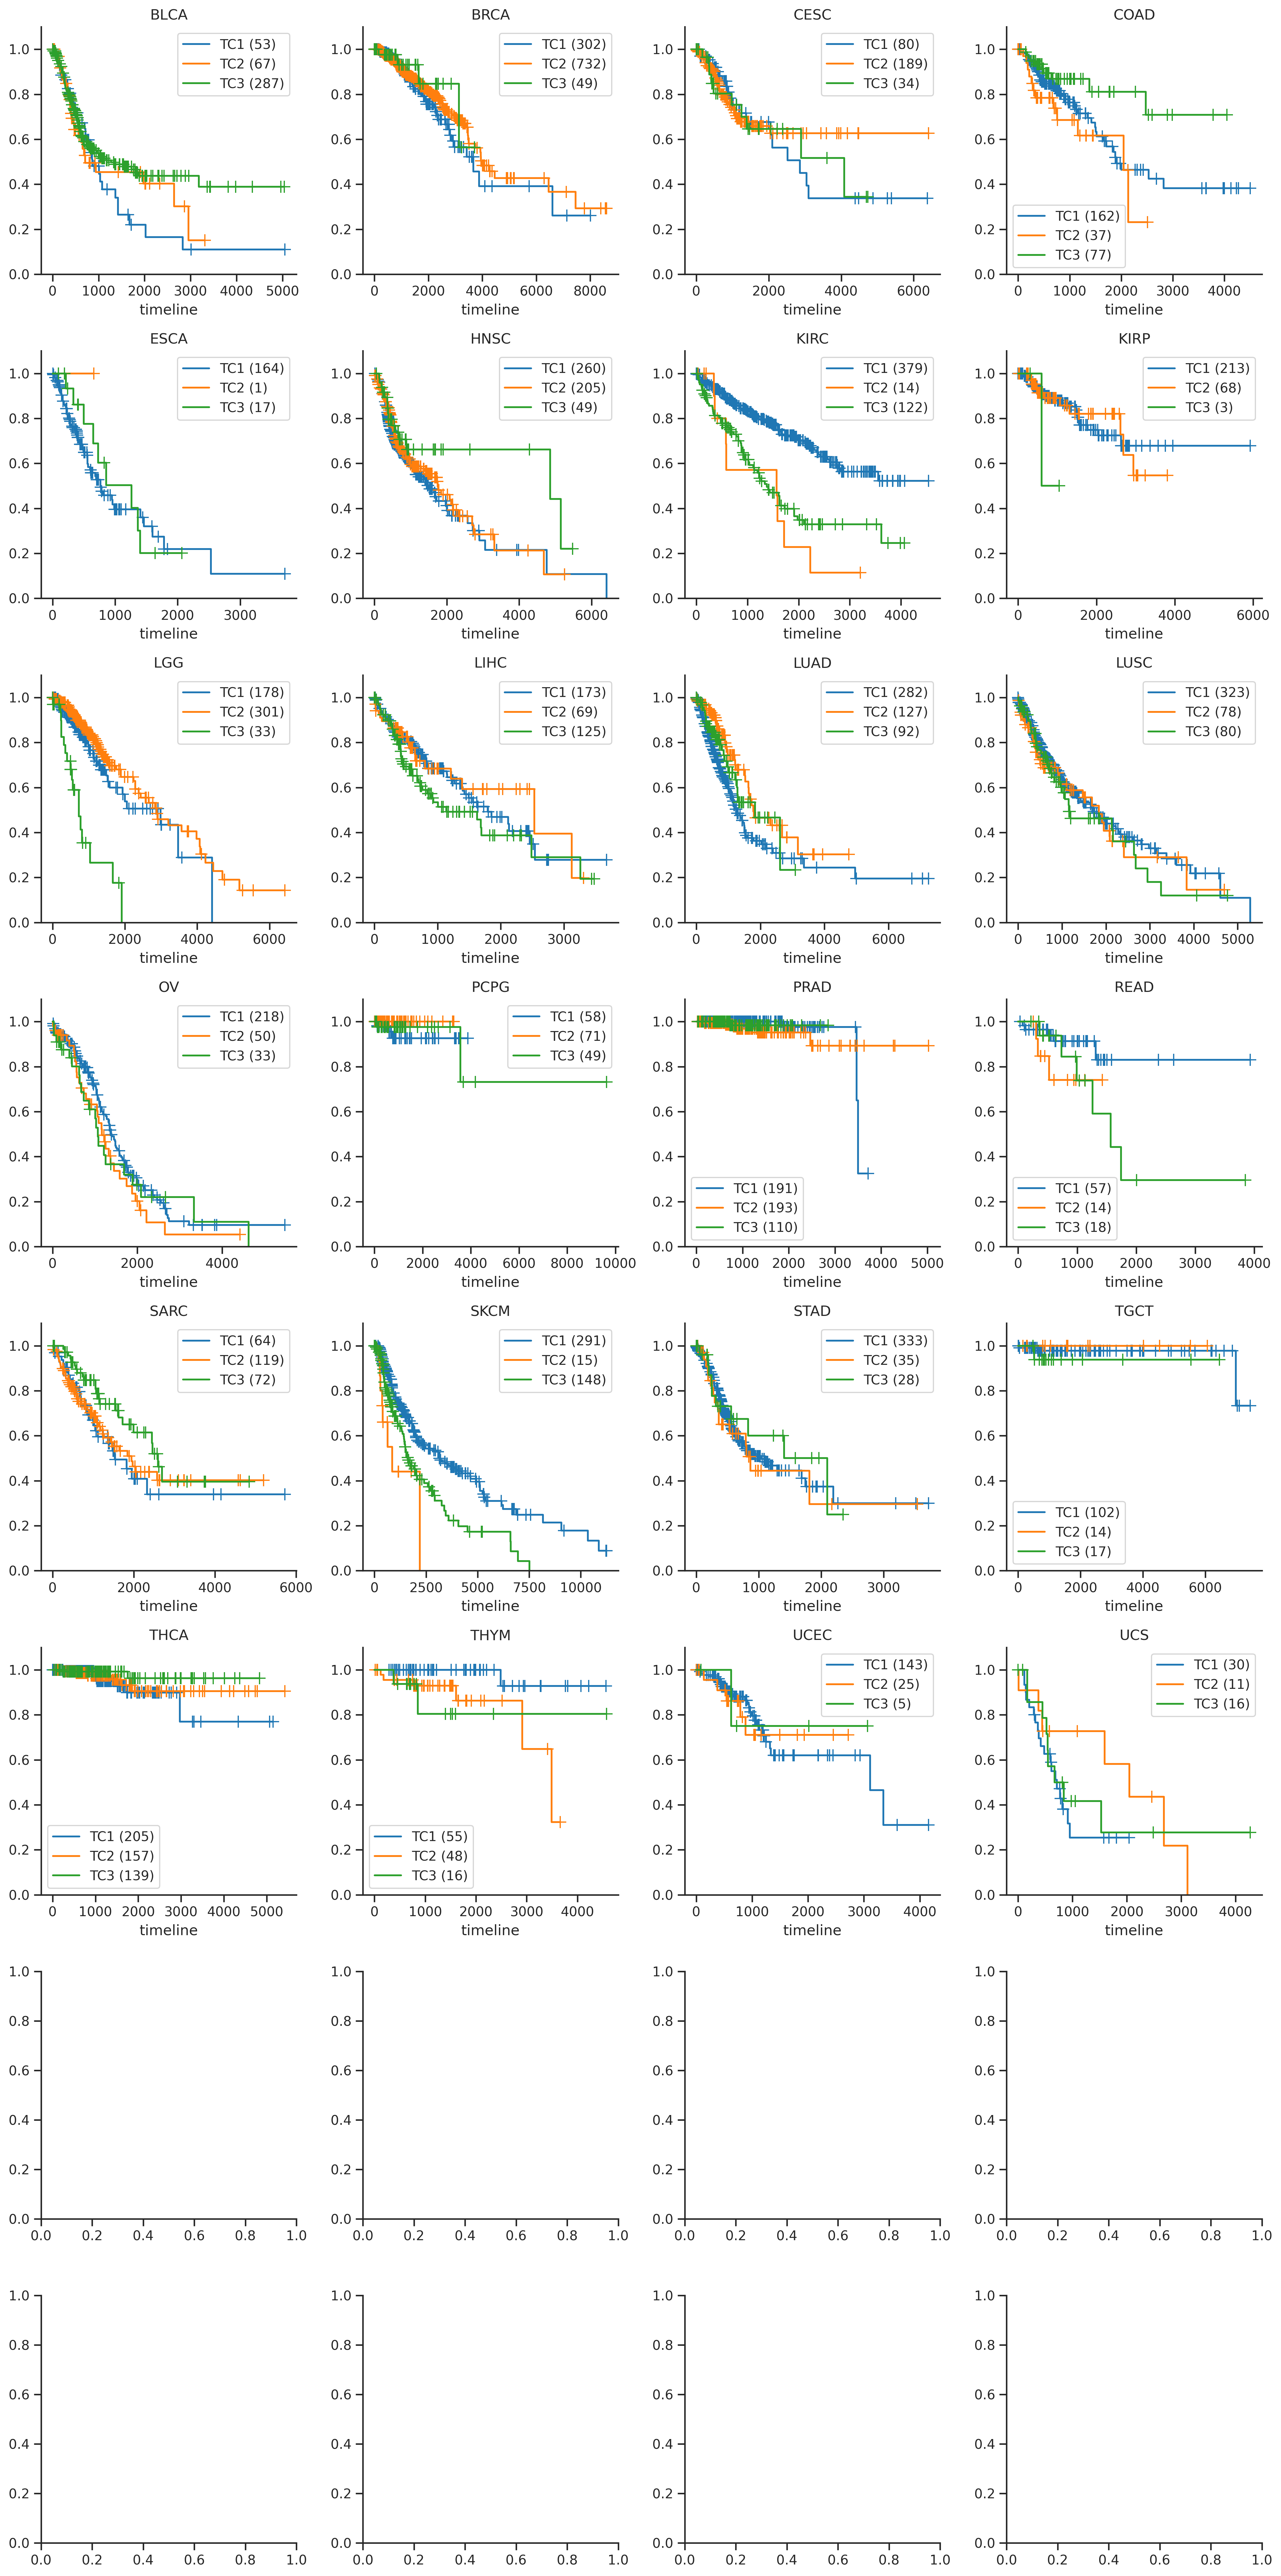

In [42]:
kmf_acr = KaplanMeierFitter() 
min_n_sample = 5

sns.set(font_scale=1, style='ticks')
fig, axes = plt.subplots(8, 4, figsize=(15, 30))

sig_df_list = []

for a, ax in zip(selected_acronym_list, axes.flatten()):
    df = survival_vs_nmf_df[survival_vs_nmf_df['cancer_type'] == a]
    df = df.dropna(subset=['cluster', duration_label, survival_val_type])
    
    n_cluster = len(df['cluster'].unique())
    assert n_cluster == 3
    
    # there are two cancer types that 
#     if n_cluster < 2:
#         kmf_acr.fit(df[duration_label], df[survival_val_type], label='TC0 ({:d})'.format(df.shape[0]))
#         kmf_acr.survival_function_.plot(ax=ax, color='k')
#         ax.set_title(a)
#     else:
    c_df_list = []
#     c_to_test = []
    for c in range(n_cluster):
        c_df = df[df['cluster'] == c]
        if c_df.shape[0] > 0:
            kmf_acr.fit(c_df[duration_label], c_df[survival_val_type], label='TC{:d} ({:d})'.format(c+1, c_df.shape[0]))
            kmf_acr.plot(ax=ax, color=colors[c], show_censors=True, censor_styles={'ms': 10, 'marker': '+'}, ci_show=False, ci_alpha=0.1)
#             if c_df.shape[0] >= min_n_sample:
#                 c_to_test += [c]

#     df = df[df['cluster'].isin(c_to_test)]
        # results = pairwise_logrank_test(df[duration_label], df['cluster'], df['vital_status'])
        # check_sig(results, comb(len(c_to_test), 2))
        
        
    df.loc[df['cluster'].isin([0]), 'cluster0vs'] = '1'
    df.loc[~df['cluster'].isin([0]), 'cluster0vs'] = '2+3'

    df.loc[df['cluster'].isin([1]), 'cluster1vs'] = '2'
    df.loc[~df['cluster'].isin([1]), 'cluster1vs'] = '1+3'

    df.loc[df['cluster'].isin([2]), 'cluster2vs'] = '3'
    df.loc[~df['cluster'].isin([2]), 'cluster2vs'] = '1+2'        
        
    sig_df_list += [check_sig_nmf(df)]
    
    ax.set_ylim(0, 1.1)
    # ax.set_xlim(0, 7000)
    ax.set_title(a)

sns.despine()
plt.tight_layout()

# plt.savefig('../figure/supplementary_nmf_survival.svg')
# plt.savefig('../figure/supplementary_nmf_survival.pdf')

In [43]:
sig_df = pd.concat(sig_df_list, axis=0).sort_values('p')
sig_df.head()
# combined_sig_df = sig_df[sig_df['corrected_p'].isnull()].sort_values(['acronym', 'p']).groupby('acronym').head(1).sort_values('p')
# combined_sig_df

level_0 level_1  test_statistic         p acronym
0     1+2       3           48.06  4.14e-12     LGG
0       1     2+3           41.37  1.26e-10    KIRC
0     1+2       3           32.77  1.04e-08    KIRC
0       1     2+3           18.37  1.82e-05    SKCM
0     1+2       3           12.58  3.90e-04    SKCM

In [44]:
sig_df = sig_df.sort_values(['acronym', 'p'], ascending=[True, True]).groupby('acronym').head(1).sort_values('p')
sig_df

level_0 level_1  test_statistic         p acronym
0     1+2       3           48.06  4.14e-12     LGG
0       1     2+3           41.37  1.26e-10    KIRC
0       1     2+3           18.37  1.82e-05    SKCM
0       1     2+3            9.28  2.32e-03    LUAD
0       1     2+3            7.25  7.09e-03    THYM
0     1+2       3            5.65  1.74e-02    COAD
0       1     2+3            4.56  3.27e-02    READ
0     1+2       3            4.18  4.09e-02    SARC
0     1+2       3            3.24  7.17e-02    LIHC
0     1+2       3            2.82  9.31e-02    HNSC
0     1+2       3            2.62  1.05e-01    BLCA
0     1+3       2            2.48  1.15e-01    PCPG
0       1     2+3            2.46  1.17e-01      OV
0     1+2       3            2.35  1.25e-01    THCA
0     1+2       3            2.26  1.33e-01    KIRP
0       1     2+3            1.65  1.99e-01     UCS
0       1     2+3            1.29  2.57e-01    BRCA
0     1+2       3            0.99  3.21e-01    TGCT
0     1+3       2            0.92  3.37e-01    PRAD
0       1     2+3            0.92  3.37e-01    LUSC
0     1+3       2            0.56  4.54e-01    ESCA
0     1+2       3            0.26  6.07e-01    STAD
0     1+3       2            0.17  6.81e-01    CESC
0     1+2       3            0.02  8.84e-01    UCEC

In [45]:
is_pass, cpval, alphac_sidak, alphac_bonf = multipletests(sig_df['p'], alpha=0.1, method='fdr_bh')
is_pass, cpval

(array([ True,  True,  True,  True,  True,  True, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False]),
 array([9.94e-11, 1.51e-09, 1.45e-04, 1.39e-02, 3.40e-02, 6.98e-02,
        1.12e-01, 1.23e-01, 1.91e-01, 2.12e-01, 2.12e-01, 2.12e-01,
        2.12e-01, 2.12e-01, 2.12e-01, 2.98e-01, 3.63e-01, 4.04e-01,
        4.04e-01, 4.04e-01, 5.19e-01, 6.63e-01, 7.11e-01, 8.84e-01]))

##### Main

LGG 3
COAD 3
SKCM 3
SARC 3
READ 3


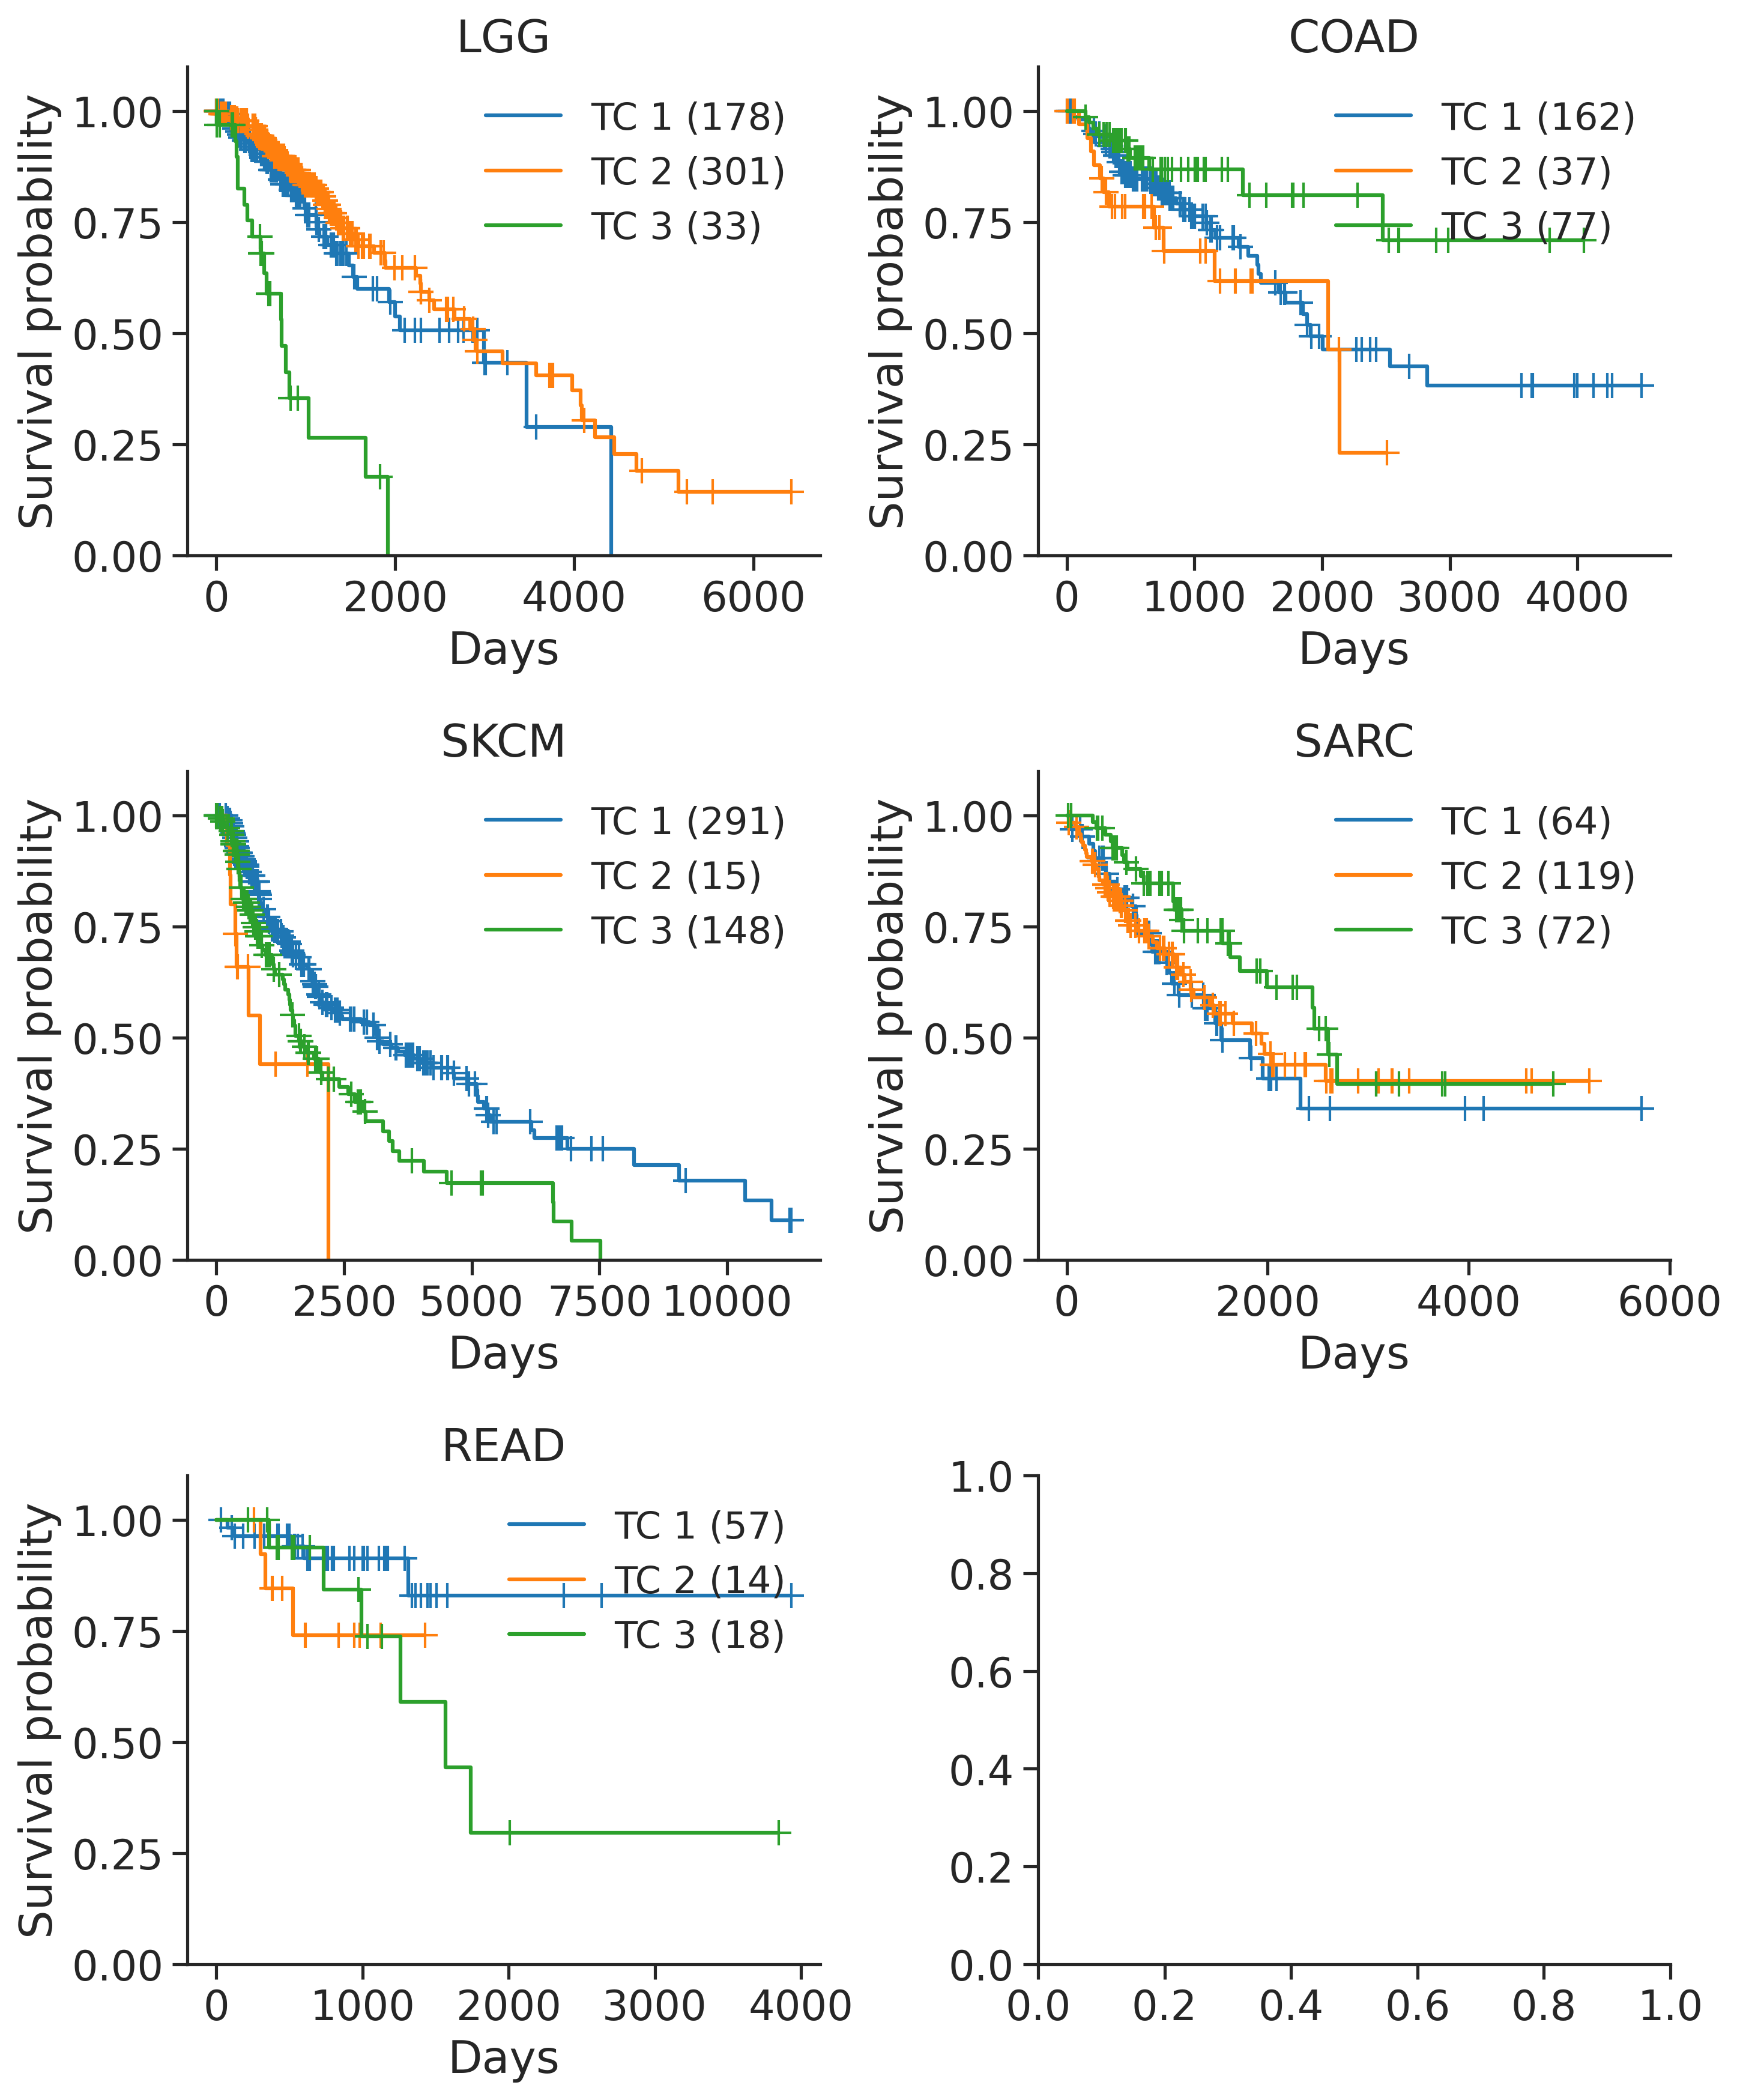

In [46]:
sns.set(style='ticks', font_scale=1.5)
fig, axes = plt.subplots(figsize=(10,12), ncols=2, nrows=3)


for a, ax in zip(['LGG', 'COAD', 'SKCM', 'SARC', 'READ'], axes.flatten()):
    df = survival_vs_nmf_df[survival_vs_nmf_df['cancer_type'] == a]
    df = df.dropna(subset=['cluster', duration_label, survival_val_type])
    
    n_cluster = len(df['cluster'].unique())
    print (a, n_cluster)
    
    # there are two cancer types that 
    if n_cluster < 2:
        kmf_acr.fit(df[duration_label], df[survival_val_type], label='TC 1 ({:d})'.format(df.shape[0]))
        kmf_acr.plot(ax=ax, color=colors[0], show_censors=True, censor_styles={'ms': 10, 'marker': '+'}, ci_show=False, ci_alpha=0.1)
        ax.set_title(a)
    else:
        c_df_list = []
        c_to_test = []
        for c in range(n_cluster):
            c_df = df[df['cluster'] == c]
            if c_df.shape[0] > 0:
                kmf_acr.fit(c_df[duration_label], c_df[survival_val_type], label='TC {:d} ({:d})'.format(c+1, c_df.shape[0]))
                kmf_acr.plot(ax=ax, color=colors[c], show_censors=True, censor_styles={'ms': 10, 'marker': '+'}, ci_show=False, ci_alpha=0.1)
        ax.set_title(a)

    ax.set_ylabel('Survival probability')
    ax.set_xlabel('Days')
    ax.set_ylim(0, 1.1)
    # ax.set_xlim(0, 7000)
    
    ax.legend(frameon=False, loc=1, fontsize='small')

sns.despine()
plt.tight_layout()

# plt.savefig('../figure/Figure1D.svg')

### Figure 1E

In [47]:
entropy_nmf_df = pd.merge(entropy_df, cluster_df[['cluster']], left_on='patient', right_index=True)
entropy_nmf_df.head()

patient acronym  entropy  entropy_bin entropy_class entropy_class2  \
0  TCGA-02-0047     GBM     2.15            3          High       Med/High   
1  TCGA-02-0055     GBM     1.69            2           Med       Med/High   
2  TCGA-02-2483     GBM     1.72            2           Med       Med/High   
3  TCGA-02-2485     GBM     1.58            2           Med       Med/High   
4  TCGA-02-2486     GBM     2.05            3          High       Med/High   

  entropy_class3  cluster  
0           High        0  
1        Low/Med        1  
2        Low/Med        1  
3        Low/Med        0  
4           High        2

LGG 85.70592883609412 1.0744667403222035e-17 4
COAD 41.987098457076364 1.6784667181145726e-08 4
SKCM 118.38666609225551 1.180892826696788e-24 4
SARC 7.399445846644277 0.1162259231296715 4
READ 28.229651762785895 1.12050075957962e-05 4


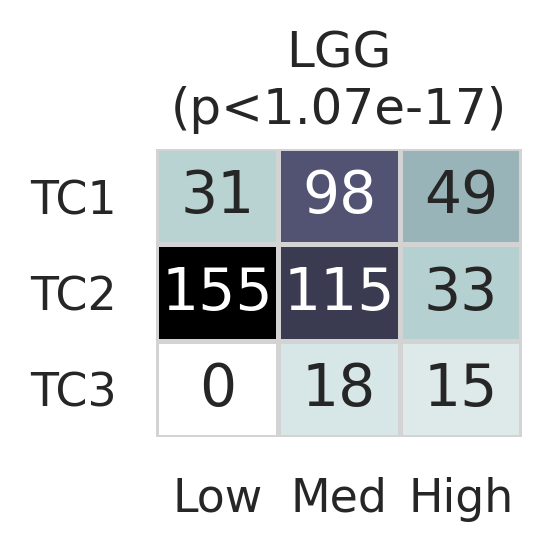

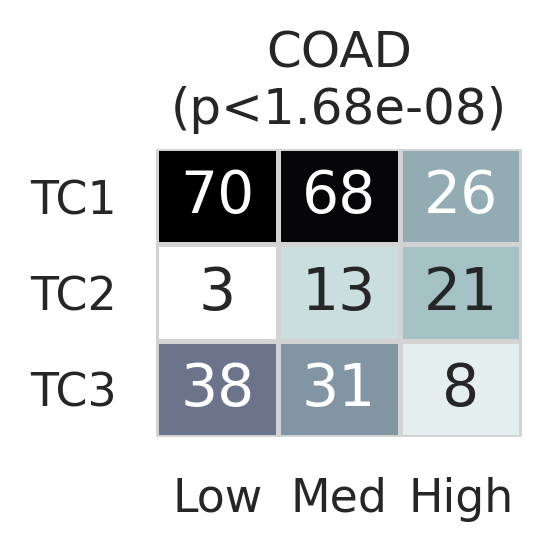

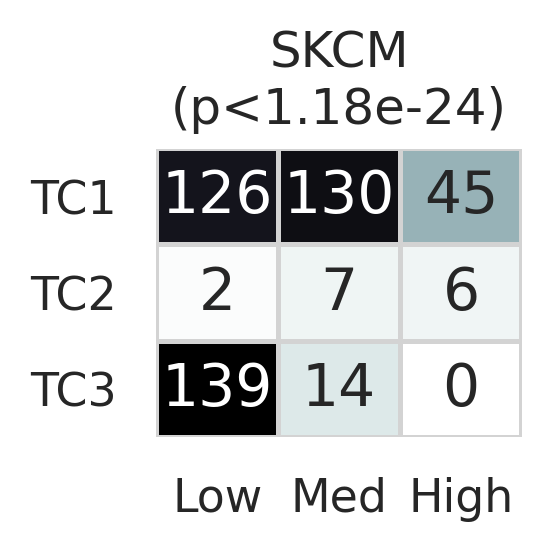

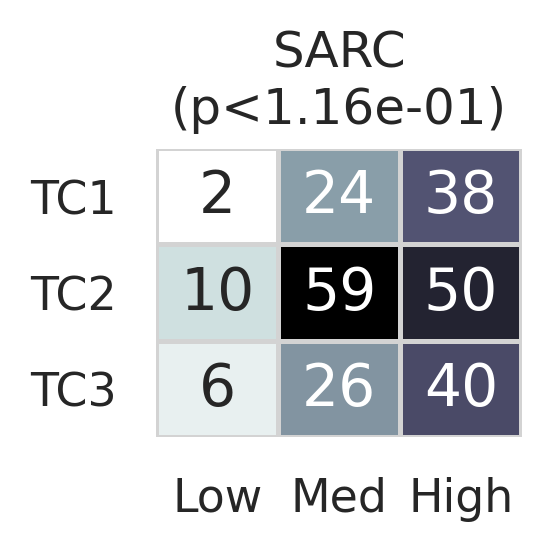

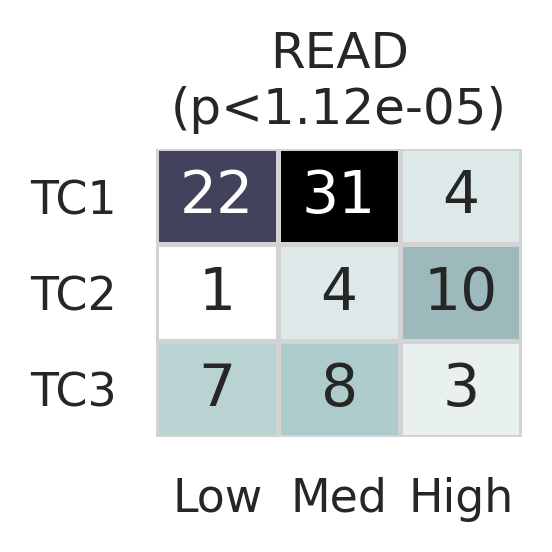

In [48]:
for cancer_type in ['LGG', 'COAD', 'SKCM', 'SARC', 'READ']:

    count_df = entropy_nmf_df[entropy_nmf_df['acronym']==cancer_type].groupby(by=['entropy_class', 'cluster']).size().reset_index().pivot(index='cluster', columns='entropy_class', values=0).fillna(0).astype(int)

    chi2, p, dof, _ = stats.chi2_contingency(count_df.values)
    print (cancer_type, chi2, p, dof)
    
    sns.set(font_scale=1)
    fig, ax = plt.subplots(figsize=(2,2))
    cmap = plt.cm.get_cmap('bone_r')

    ax = sns.heatmap(count_df[['Low', 'Med', 'High']], cmap=cmap, annot=True, annot_kws={'fontsize':14}, fmt='d', linewidth=1, linecolor='lightgrey', cbar=False)
    ax.set_yticklabels(['TC1', 'TC2', 'TC3'], rotation=0)
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    plt.title("{}\n(p<{:.2e})".format(cancer_type, p))
    plt.tight_layout()
    plt.savefig('../figure/orthogonal_{}.svg'.format(cancer_type))

In [51]:
assert False

AssertionError: 

# Below is not in use

In [49]:
# See nok_ith_vs_nmf.ipynb

# cancer_type = 'LGG'
# # cancer_type = 'SARC'

# cnt_df = survival_vs_entropy_df[survival_vs_entropy_df['acronym']==cancer_type][['sample_id', 'cluster', 'sort_entropy']]
# cnt_df = cnt_df.groupby(by=['cluster', 'sort_entropy']).count().reset_index().pivot(index='cluster', columns='sort_entropy')

# cnt_df

In [52]:
union_df = pd.DataFrame(index=cnt_df.index, columns=cnt_df.columns).fillna(0)
union_df = ((union_df + cnt_df.sum()).T + cnt_df.sum(axis=1)).T
union_df

In [ ]:
jc_df = cnt_df / (union_df - cnt_df)
jc_df.columns = ['Low', 'Med', 'High']
jc_df.index = ["TC {}".format(i+1) for i in jc_df.index]

jc_df = jc_df.fillna(0)

jc_df

In [ ]:
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(3,4.5))
cmap = plt.cm.get_cmap('bone_r')

ax = sns.heatmap(jc_df.T, cmap=cmap, vmin=0, vmax=0.5, annot=True, annot_kws={'fontsize':16}, fmt='.2f', linewidth=1, linecolor='lightgrey', cbar_kws={"label":"Jaccard index", "orientation": "horizontal", "shrink": 1, 'aspect':5})

ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot
bottom, top = ax.get_ylim()
# ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title(cancer_type)
plt.tight_layout()

plt.savefig('../figure/Figure1E_{}.svg'.format(cancer_type))